In [260]:
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
import csv
import datetime
import itertools
import os
import pandas as pd
import statistics
import statistics
from sklearn.cluster import KMeans
from collections import Counter
from scipy.stats import skew
import random
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.signal import savgol_filter
from torch_geometric.data import Data
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, GCNConv
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from torch_geometric.nn import GATConv


## contents

1. [Pre-GNN Evaluation of Trial Data](#1)

    1.1 [LDA](#1.1)
    
    1.2 [ROC CURVES](#1.2)
        
2. [Pre-GNN Consolidated Weekly Graphs of Observational Data](#2)


3. [GNN](#3)


4. [Post-GNN Evaluation of Trial Data](#4)

    4.1 [LDA](#4.1)
    
    4.2 [ROC CURVES](#4.2)

5. [Pre-GNN Consolidated Weekly Graphs of Observational Data](#5)


# 1. Pre-GNN Evaluation of Trial Data <a class="anchor" id="1"></a>


### 1. LDA <a class="anchor" id="1.1"></a>


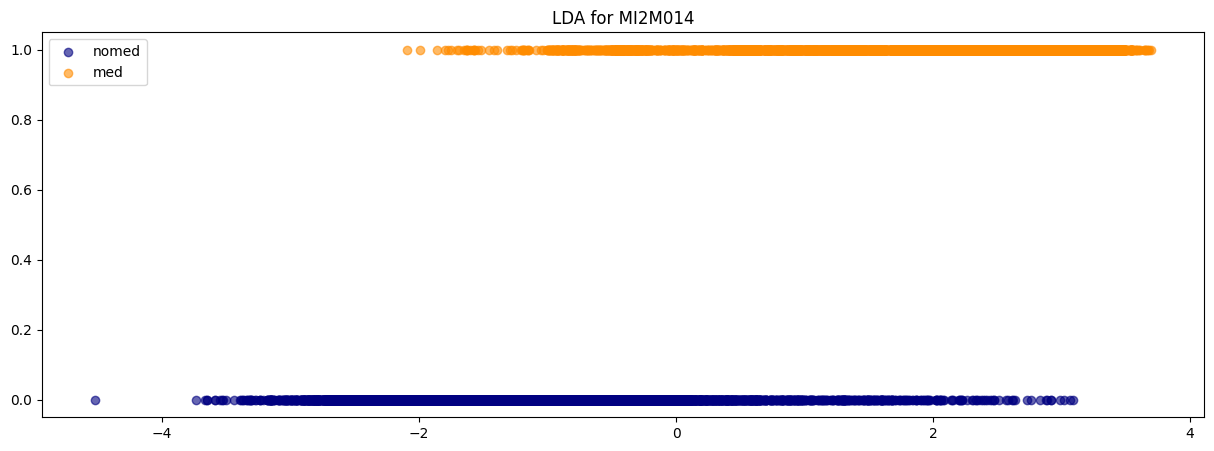

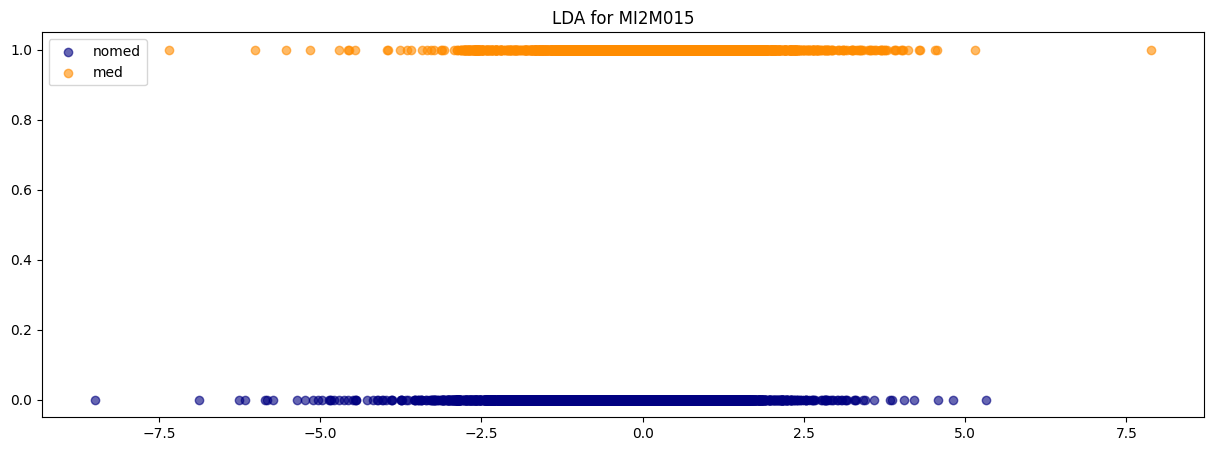

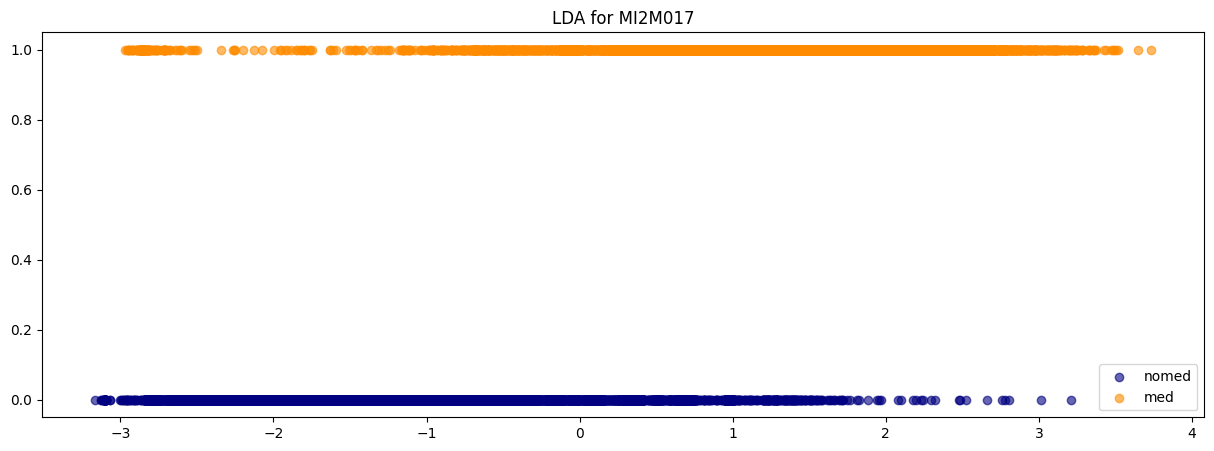

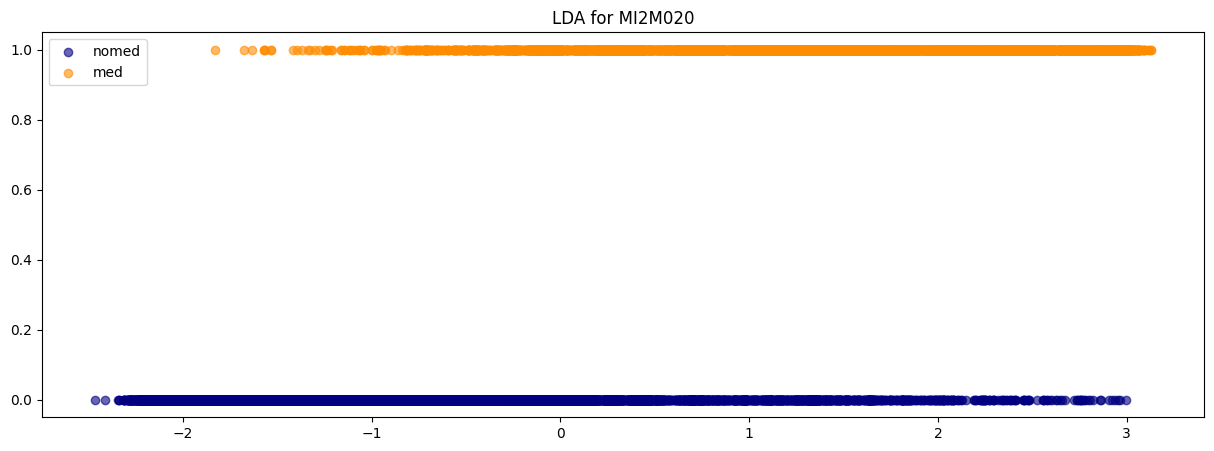

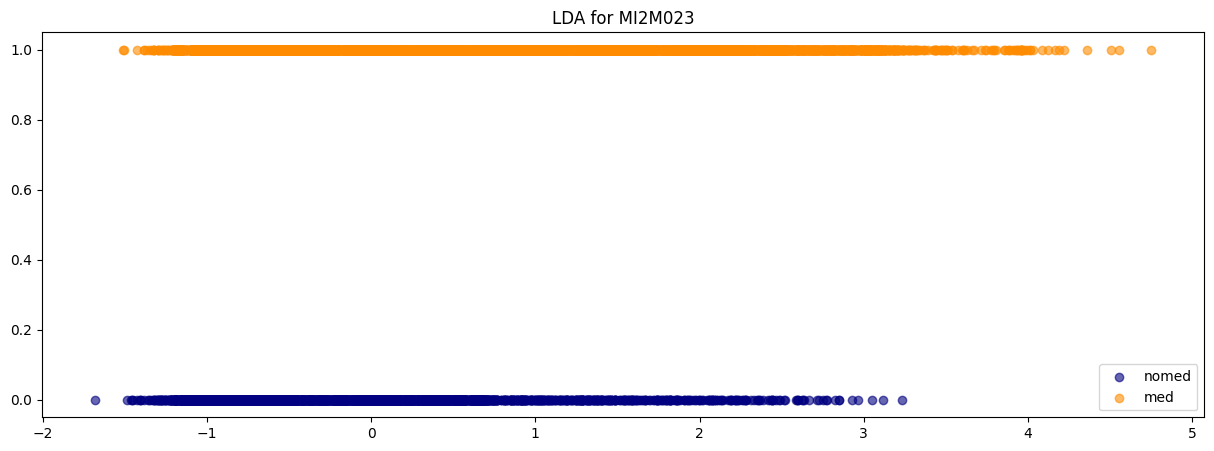

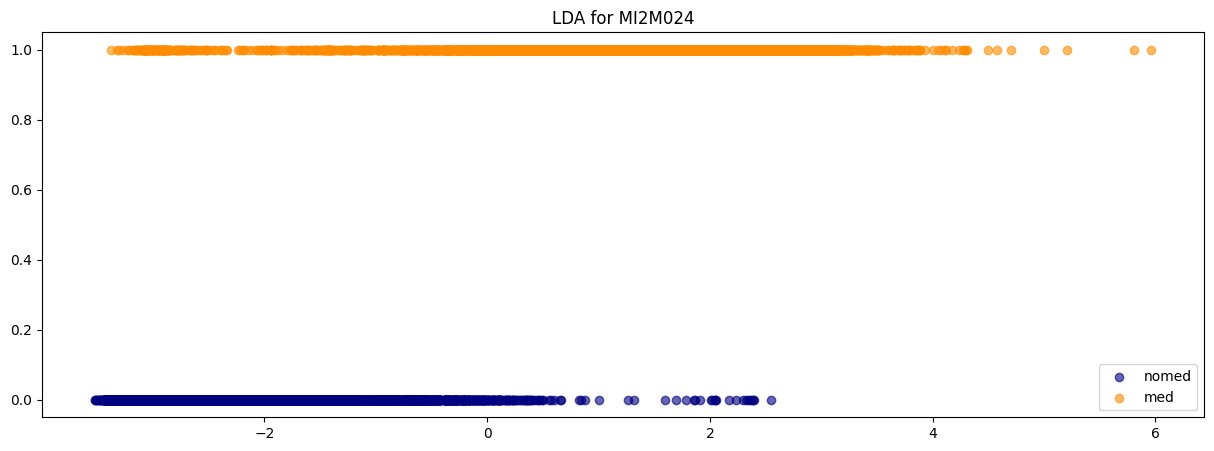

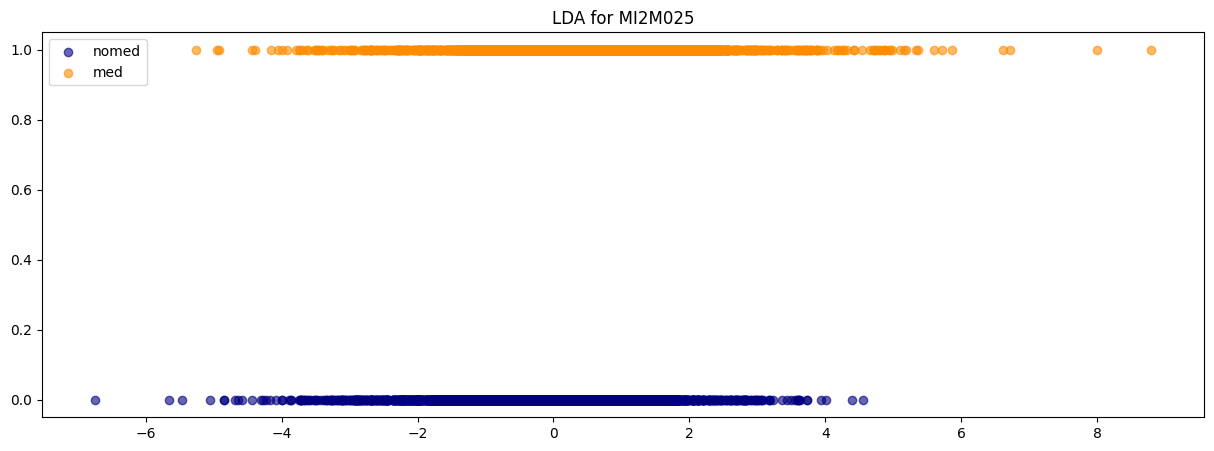

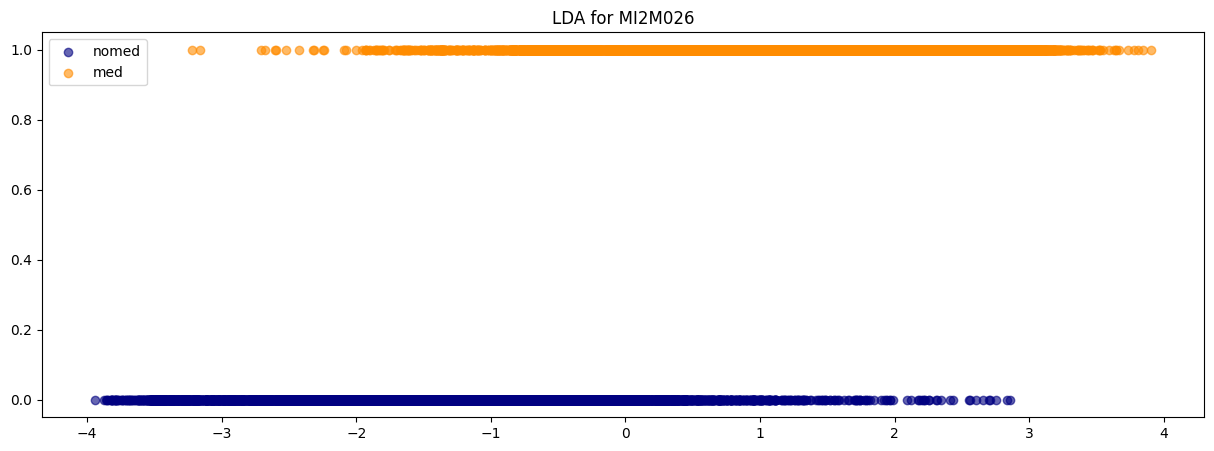

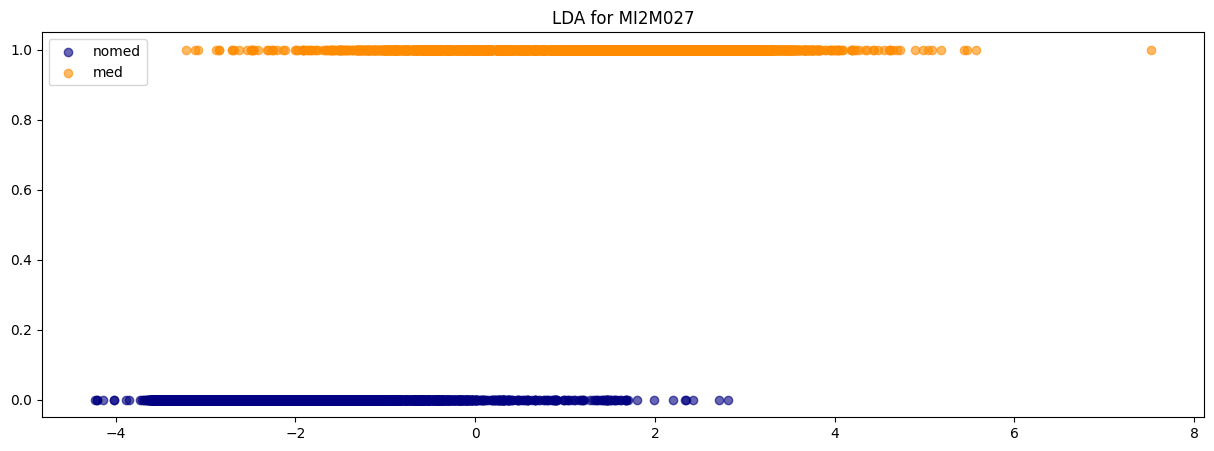

In [261]:
trial_data = pd.read_csv("Empatica data.csv")
unique_users = trial_data['user'].unique()

for user in unique_users:
    med_status = {"nomed": 0,"med": 1}
    windowed_data = trial_data[trial_data['user'] == user]
    windowed_data = windowed_data.drop(['documentation_day','user'],axis=1)
    windowed_data.rename(columns={'med':'target'}, inplace=True)
    X_train = windowed_data.drop(['target'],axis=1).reset_index()
    Y_train = windowed_data['target'].reset_index()
    optional_med_status = np.array([0,1])
    if optional_med_status.shape[0] == 2:
        lda_dim = 1
    elif optional_med_status.shape[0] < 2:
        print('fail: not enough status for med analysis')
    else:
        lda_dim = 2
    X_train = X_train.drop(['index'],axis=1)
    X_r = X_train.values
    y   = Y_train['target'].values
    target_names = np.array(["nomed", "med"])
    
    
    if lda_dim == 2:
        lda = LinearDiscriminantAnalysis(n_components=2)
        X_r2 = lda.fit(X_r, y).transform(X_r)
        df = pd.DataFrame({'lda_value1':X_r2[:,0],'lda_value2':X_r2[:,1],'Label':y})
    
        colors = ["navy", "darkorange","cyan"]
        plt.figure()
        for color, i, target_name in zip(colors, list(optional_med_status), target_names):
            plt.scatter(
                X_r2[y == i,0], X_r2[y == i,1], alpha=0.6, color=color, label=target_name
            )
        plt.legend(loc="best", shadow=False, scatterpoints=1)
        plt.title("LDA all states")
        plt.savefig(save_path + 'lda.png')
        plt.show()
        
        sil_score = []
        p_value   = []
        x1 = X_train.values[y==0]
        for stat in optional_med_status:
            if stat ==0:
                continue
            x2 = X_train.values[y==stat]
            x3 = np.concatenate((x1,x2),axis=0)
            sil_score.append(metrics.silhouette_score(x3,lda.predict(x3),metric='euclidean'))
            p_value.append(stats.ttest_ind(a=X_r2[y==0,0],b=X_r2[y==i,0],equal_var=False))
            
        X_r = X_train.values
        y   = Y_train['target'].values
        lda = LinearDiscriminantAnalysis(n_components=2)
        X_r2 = lda.fit(X_r, y).transform(X_r)
        without_center = [X_r2[y == 0,0].mean(), X_r2[y == 0,1].mean()]
        colors = ["darkorange",'cyan']
        plt.figure()
        for color, i, target_name in zip(colors, [1,2], target_names[1:]):
            plt.scatter(
                X_r2[y == i,0] - without_center[0], X_r2[y == i,1] - without_center[1], alpha=0.6, color=color, label=target_name
            )
        plt.legend(loc="best", shadow=False, scatterpoints=1)
        plt.title("LDA Aligned")
        plt.show()
        
        with1 = X_r2[y == 1][:,0].mean()
        with2 = X_r2[y == 2][:,0].mean()
        without = X_r2[y == 0][:,0].mean()
        colors = ['navy',"darkorange",'cyan']
        for color, i, target_name in zip(colors, [0,1,2], target_names):
            plt.scatter(
                X_r2[y == i][:,0].mean(), X_r2[y == i][:,0].mean(), alpha=0.6, color=color, label=target_name
            )
        plt.legend(loc="best", shadow=False, scatterpoints=1)
        plt.title("LDA Aggregate")
        plt.show()
    
    plt.rcParams['figure.figsize'] = [15, 5]
    
    if lda_dim == 1:
        lda = LinearDiscriminantAnalysis(n_components=1)
        X_r2 = lda.fit(X_r, y).transform(X_r)
        df = pd.DataFrame({'lda_value':X_r2[:,0],'Label':y})
        colors = ["navy", "darkorange"]
        plt.figure()
        for color, i, target_name in zip(colors, list(optional_med_status), target_names):
            plt.scatter(
                X_r2[y == i], y[y==i], alpha=0.6, color=color, label=target_name
            )
        plt.legend(loc="best", shadow=False, scatterpoints=1)
        plt.title(f"LDA for {user}")
        #plt.savefig(save_path + 'lda.png')
        plt.show()


### 1.2. ROC CURVE <a class="anchor" id="1.2"></a>


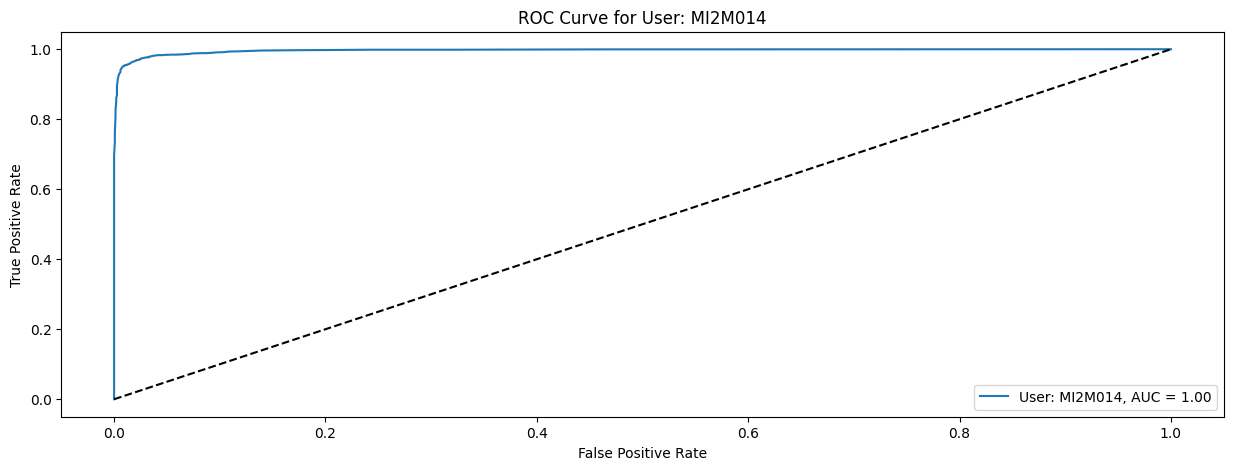

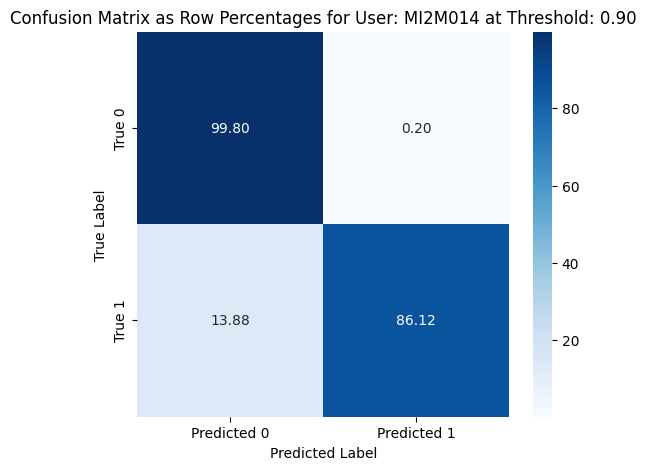

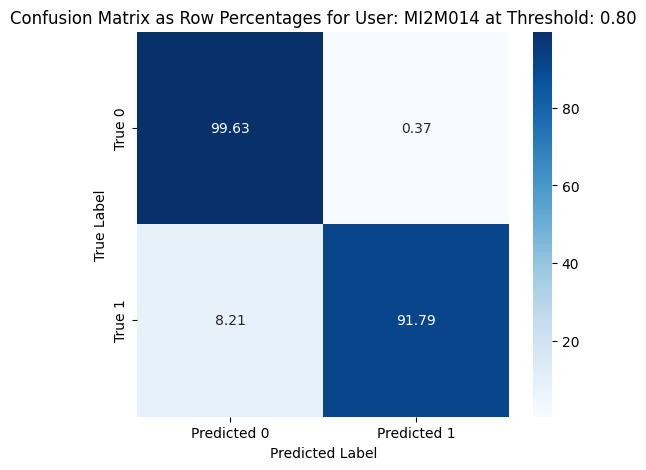

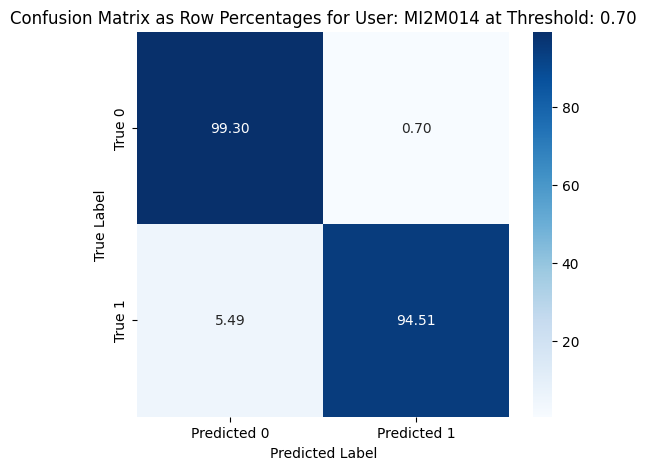

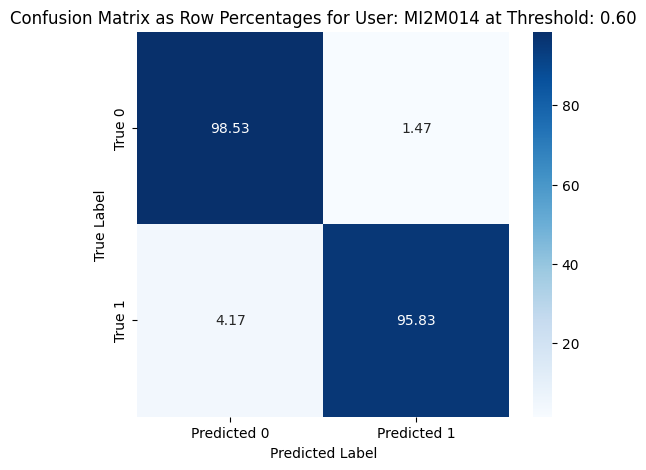

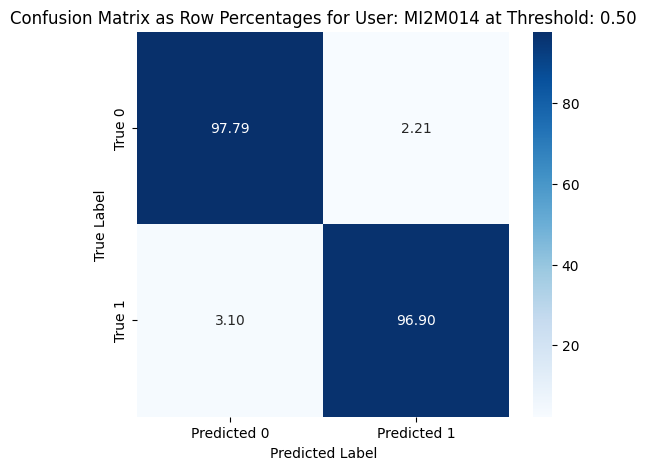

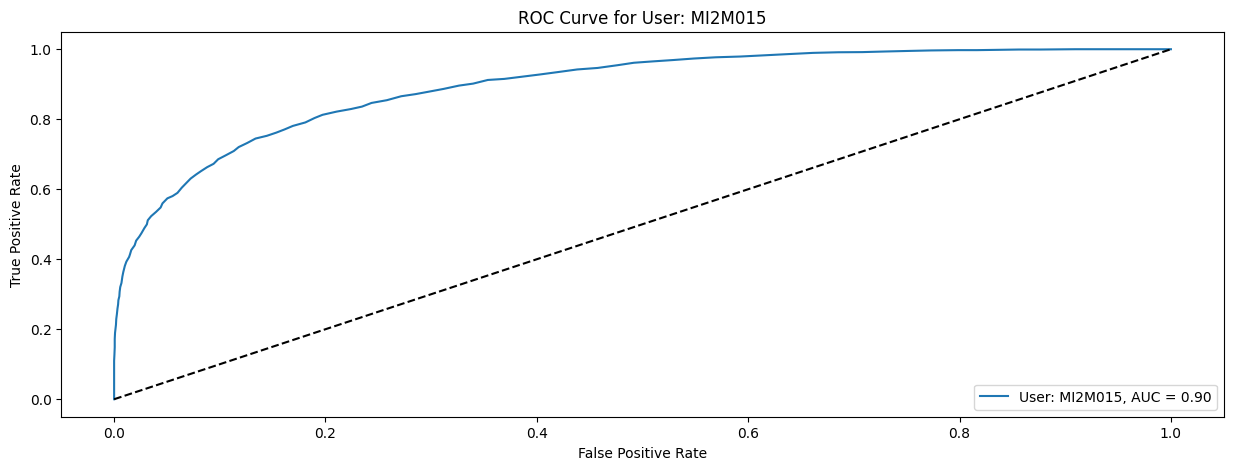

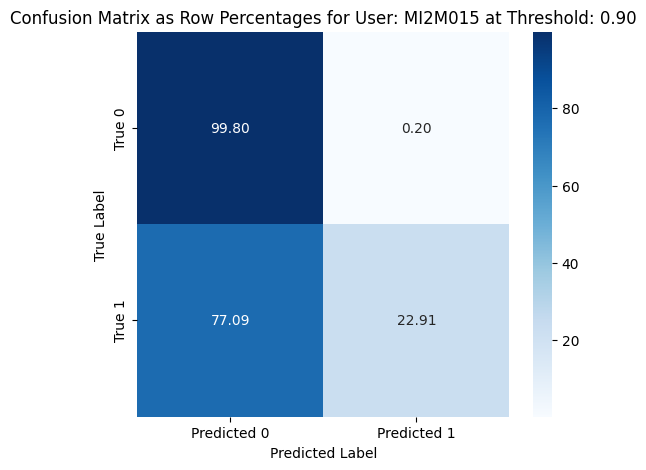

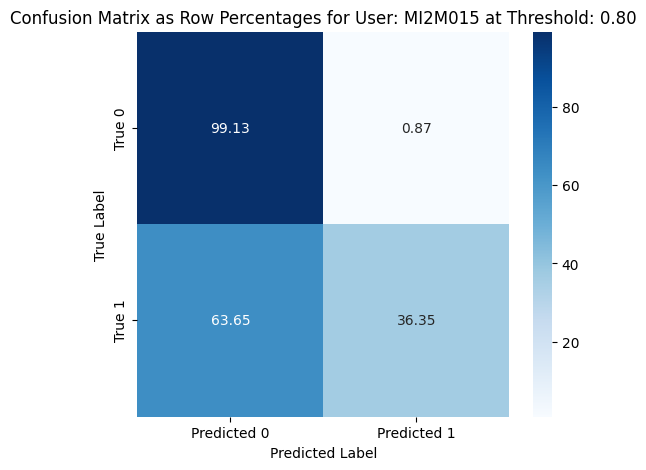

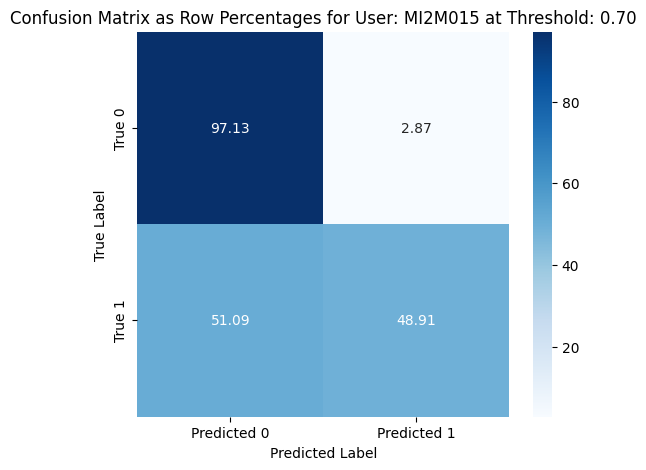

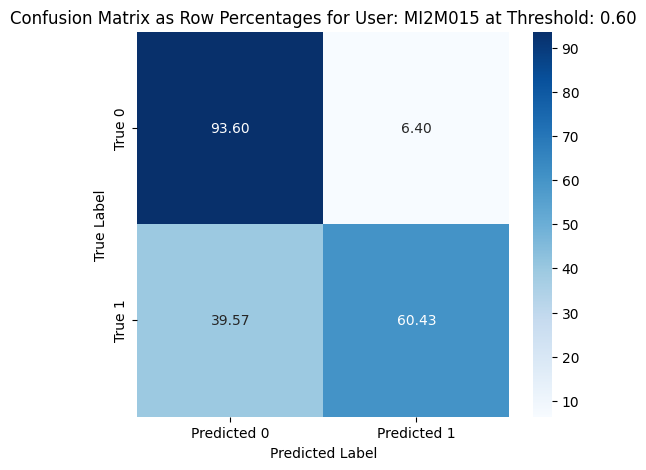

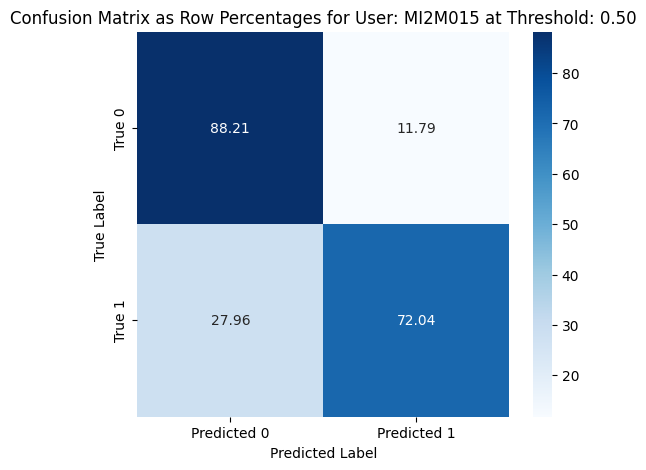

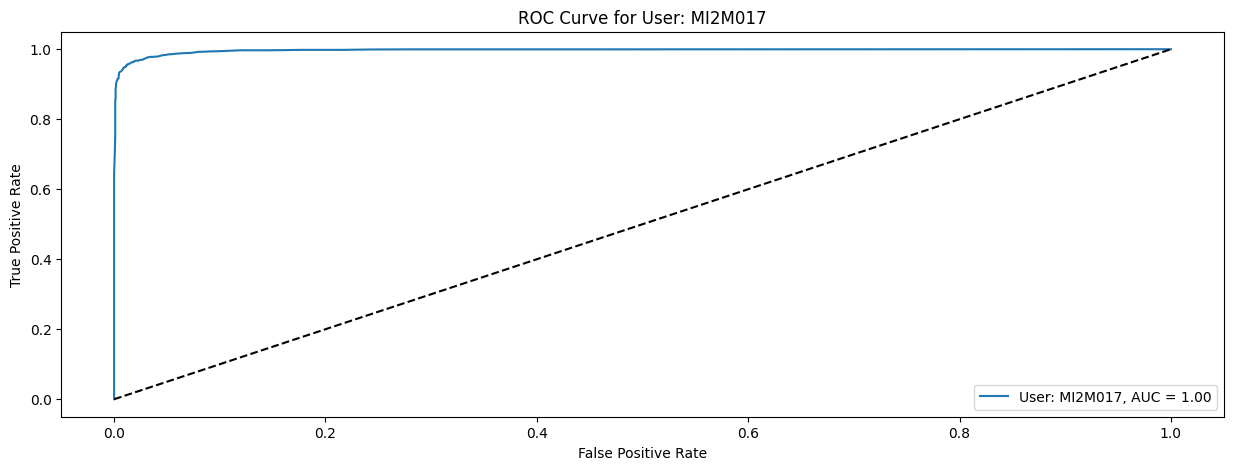

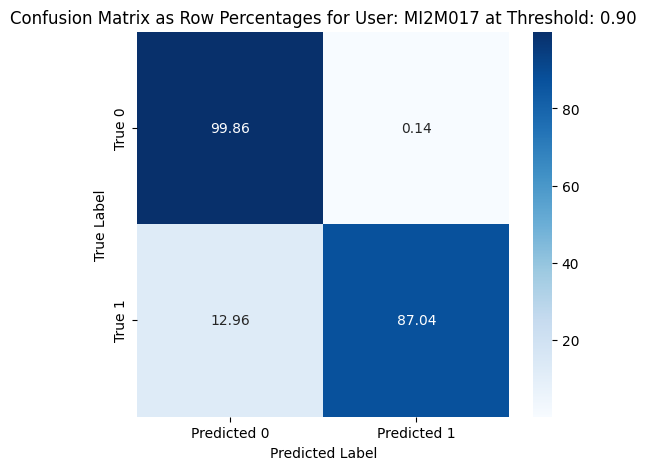

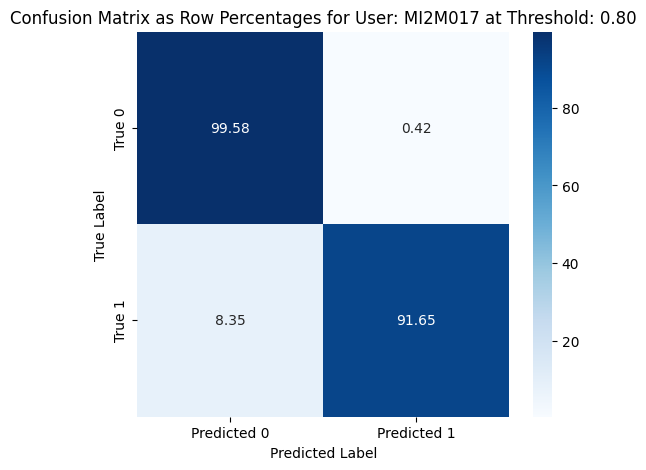

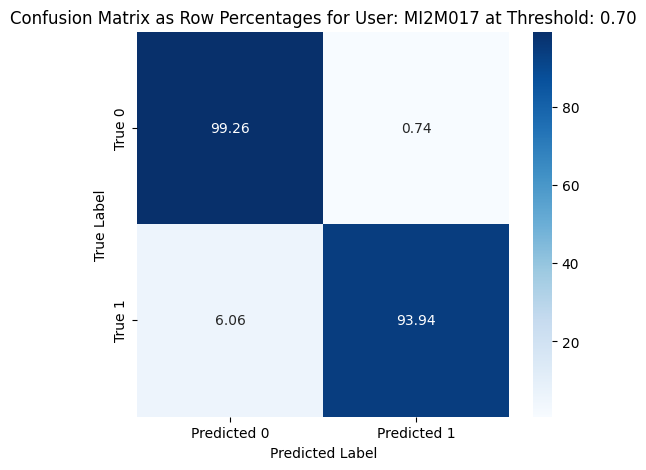

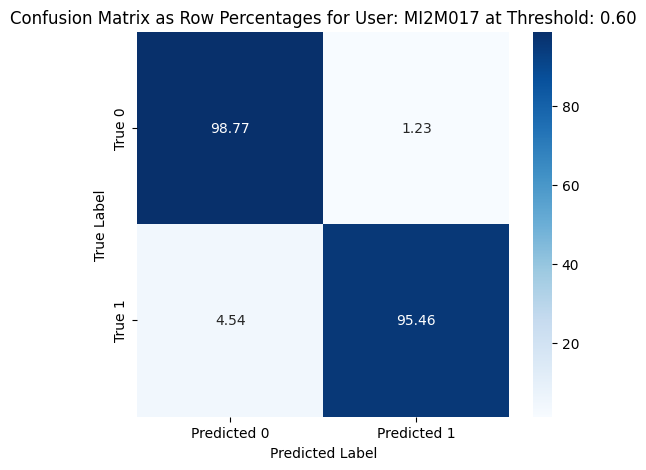

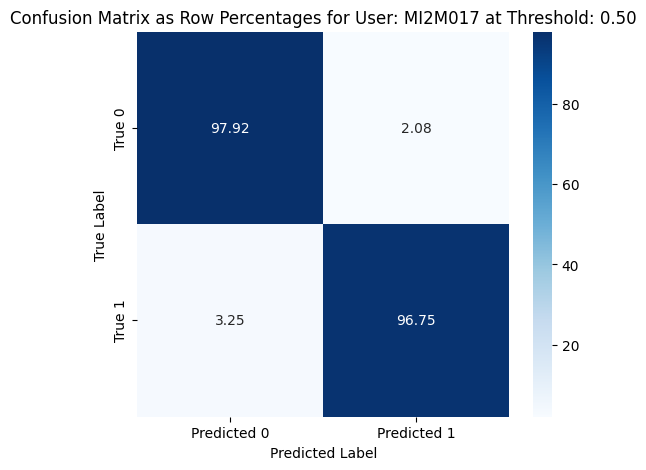

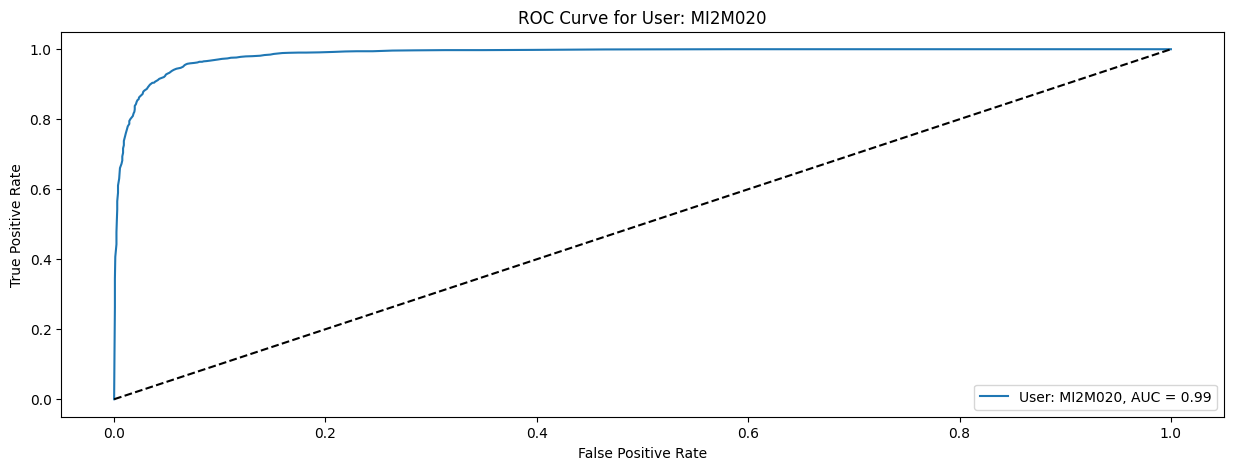

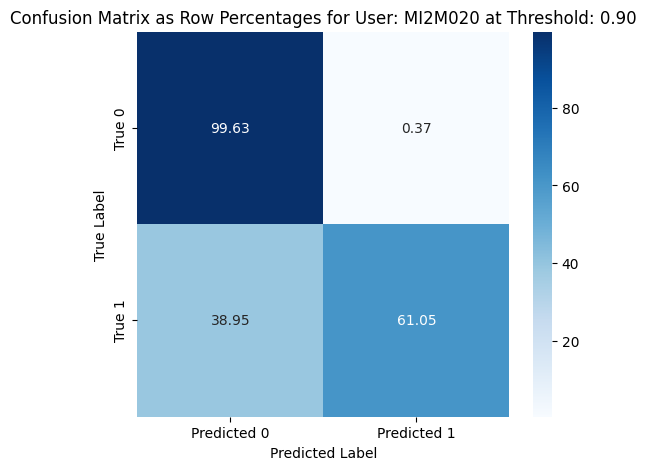

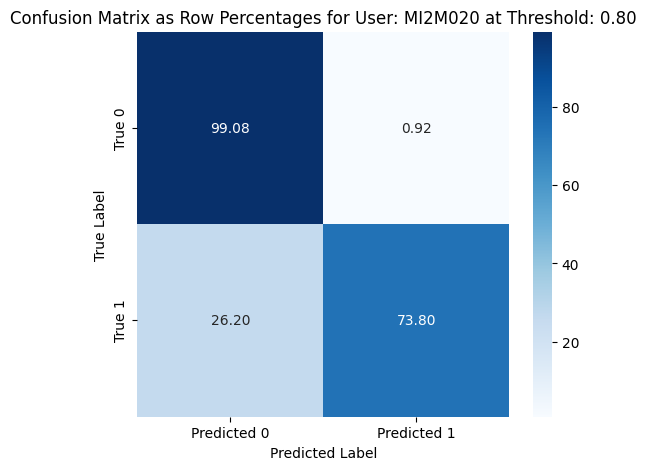

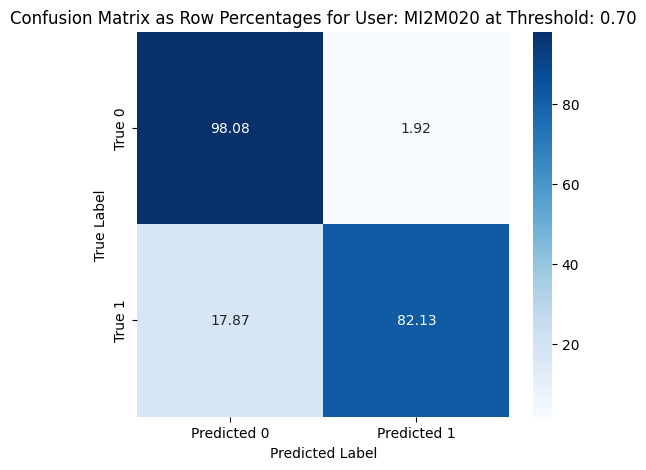

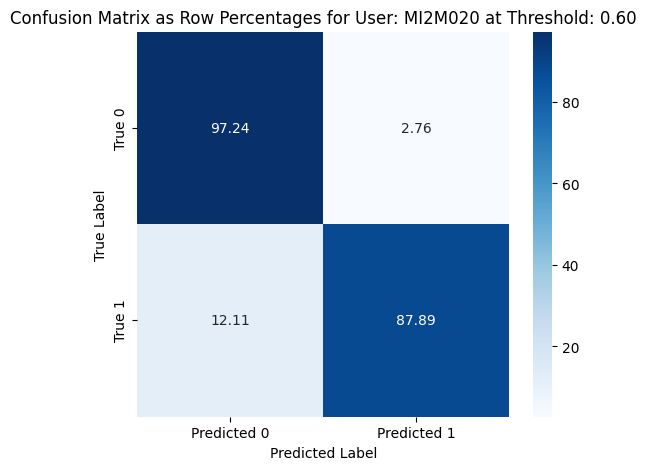

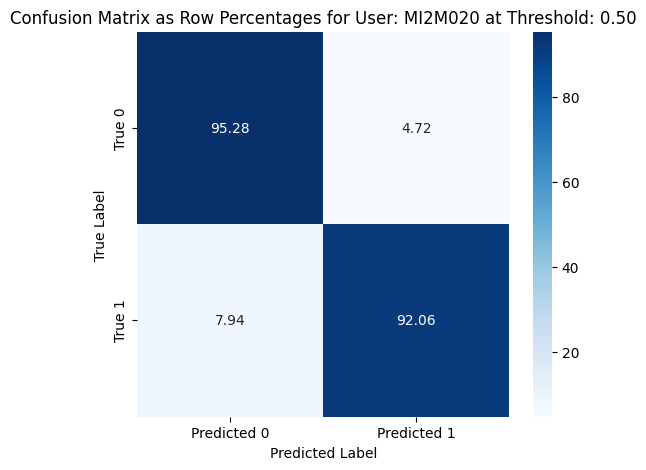

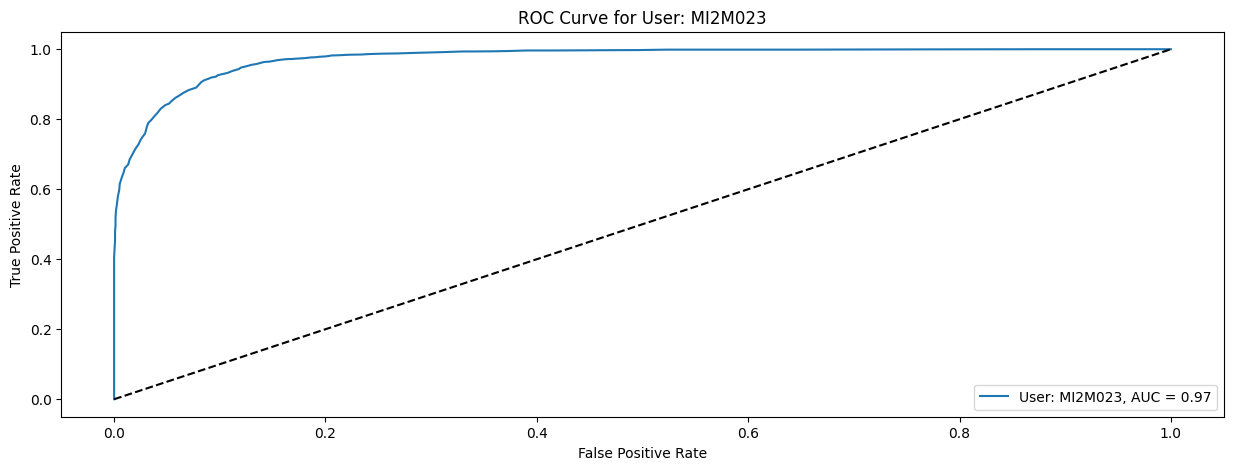

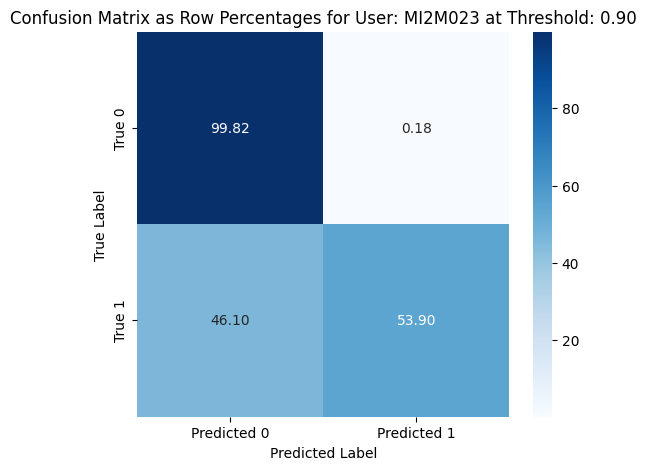

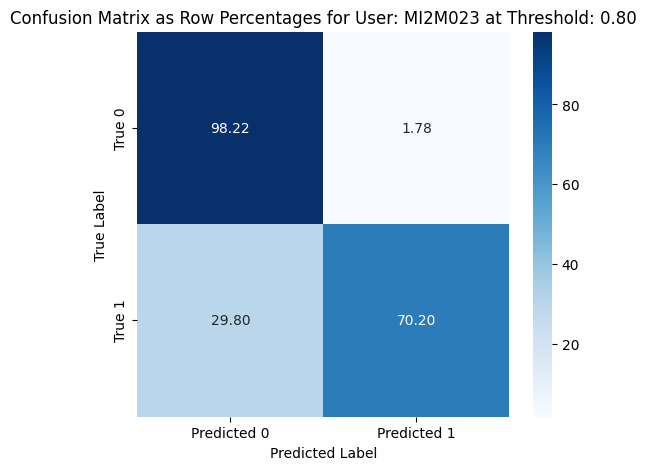

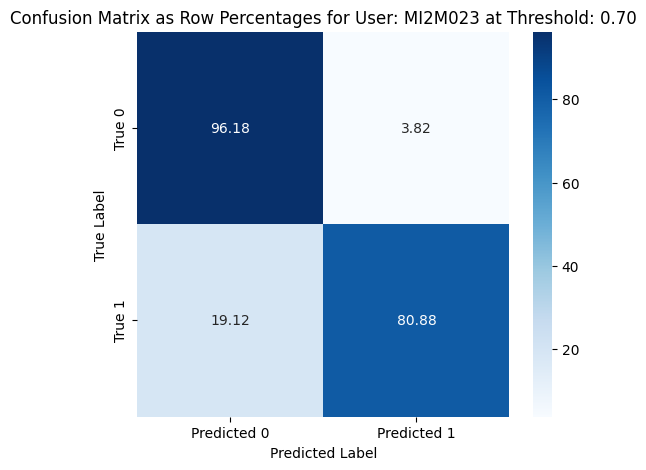

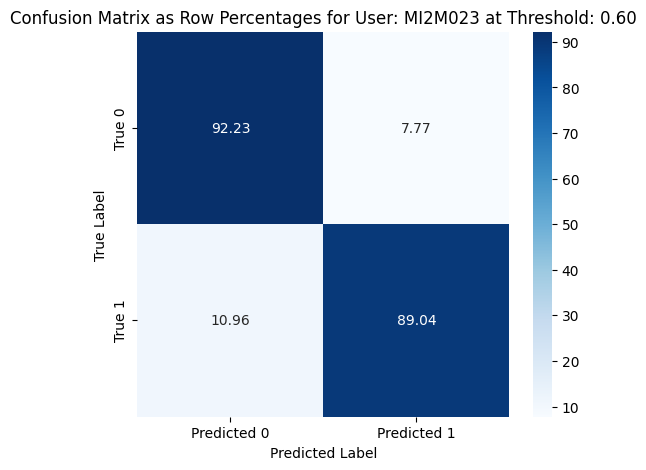

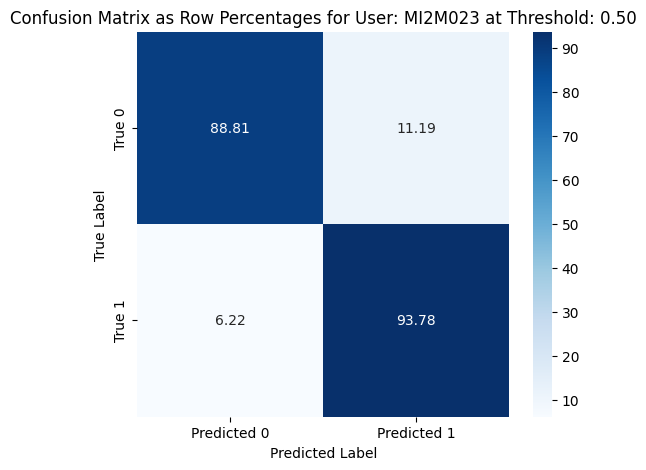

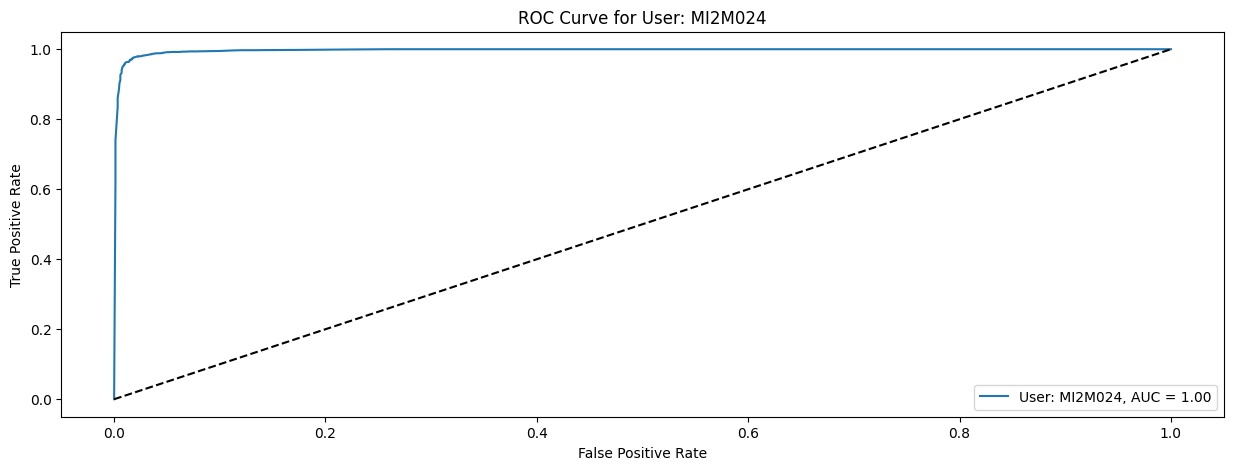

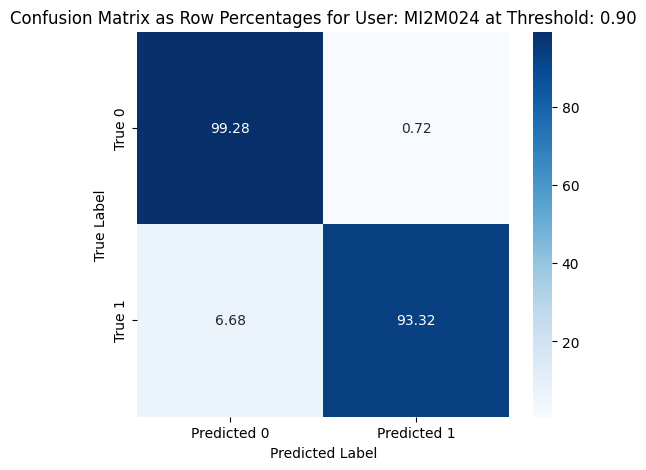

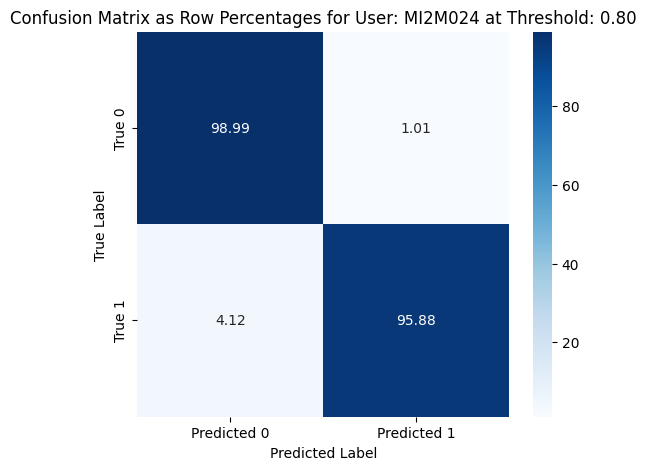

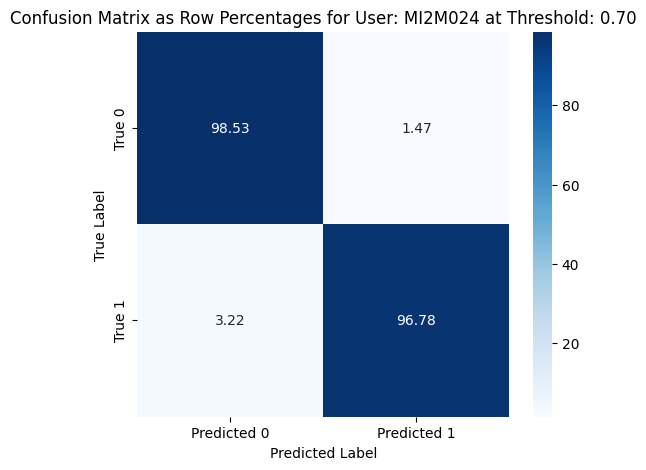

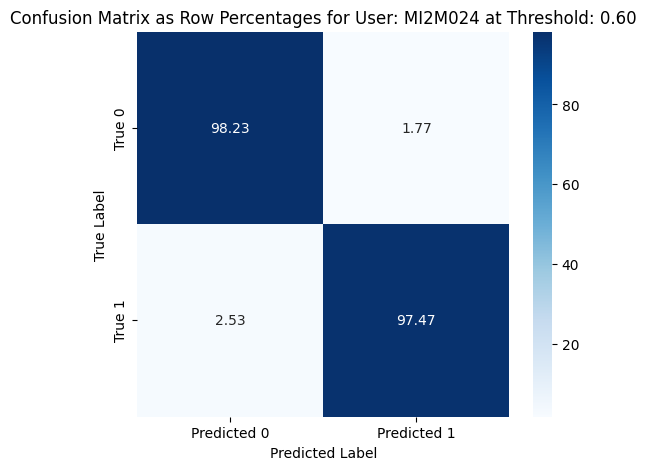

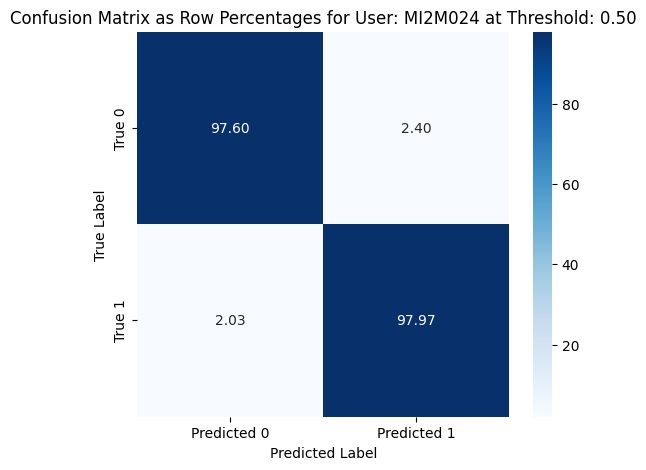

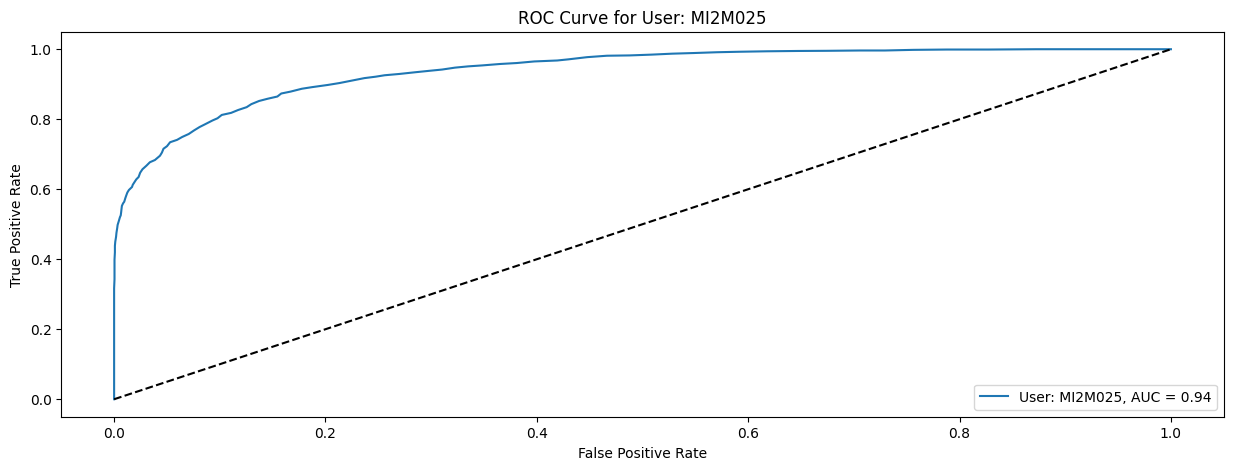

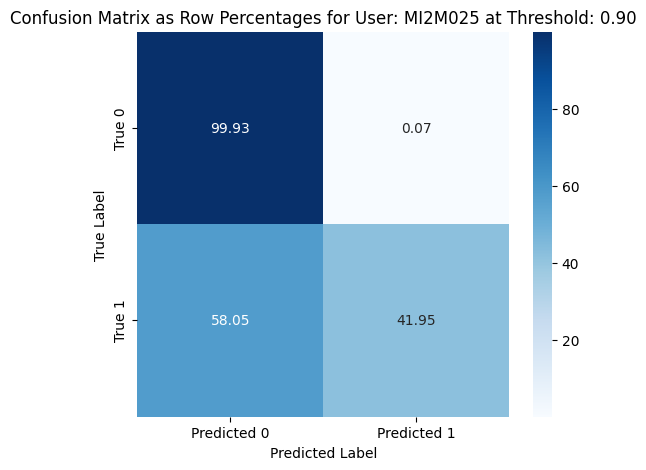

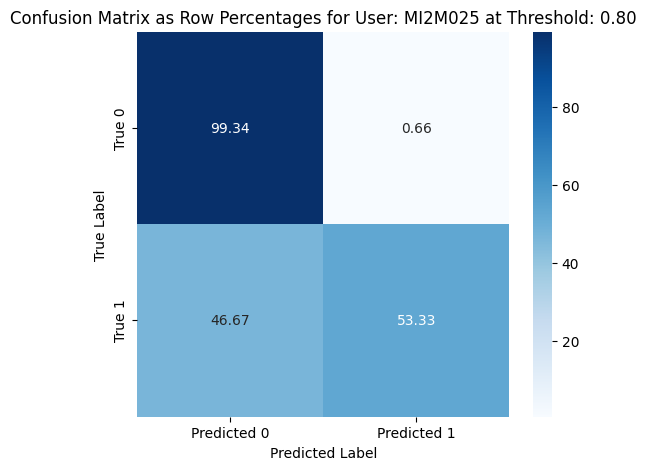

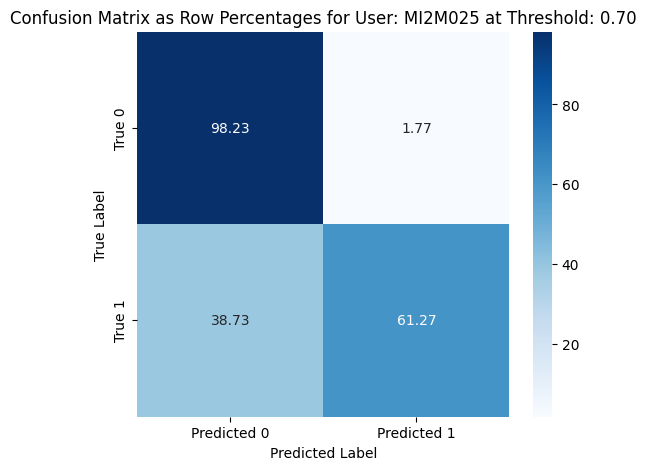

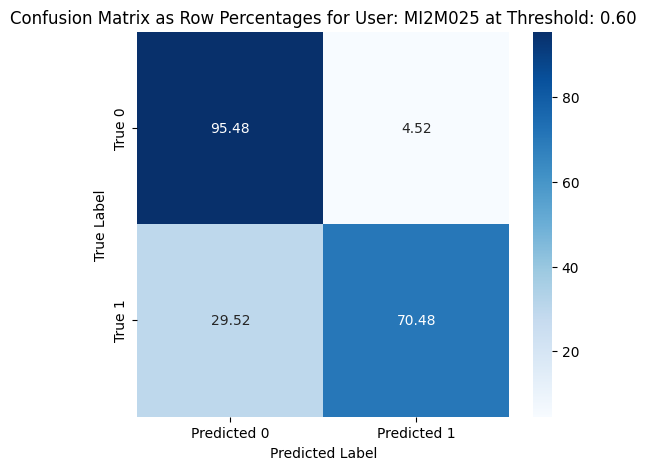

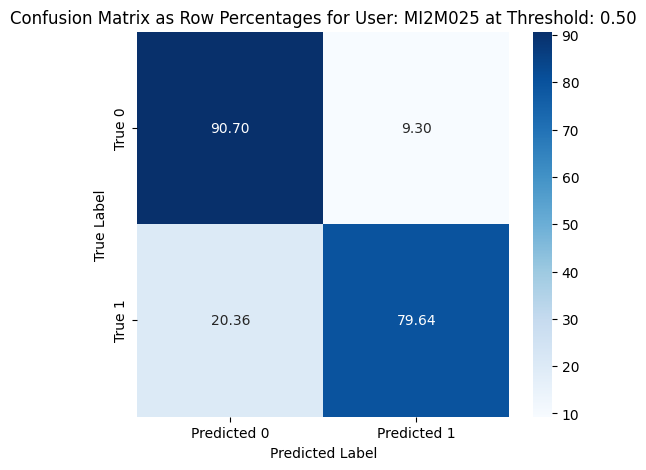

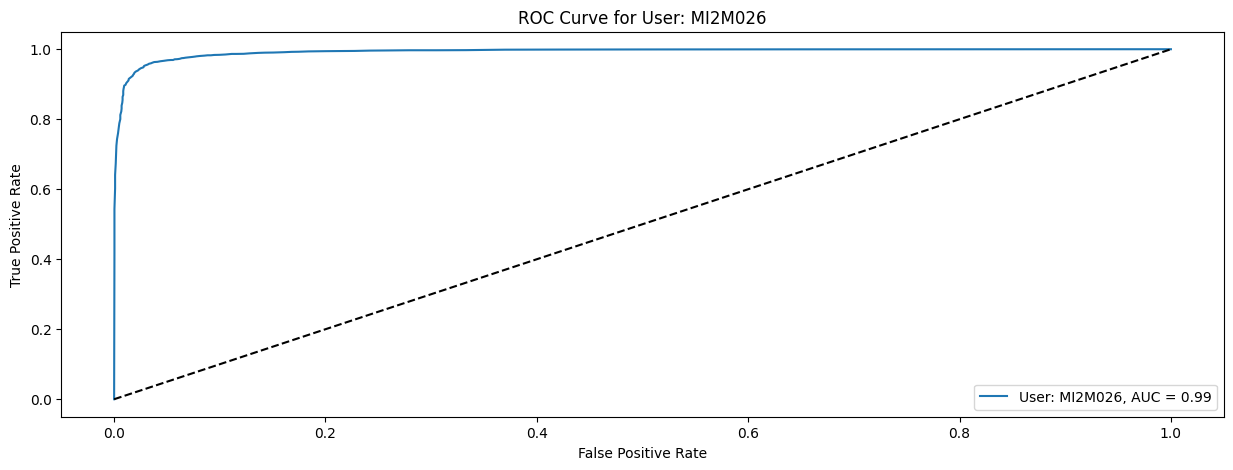

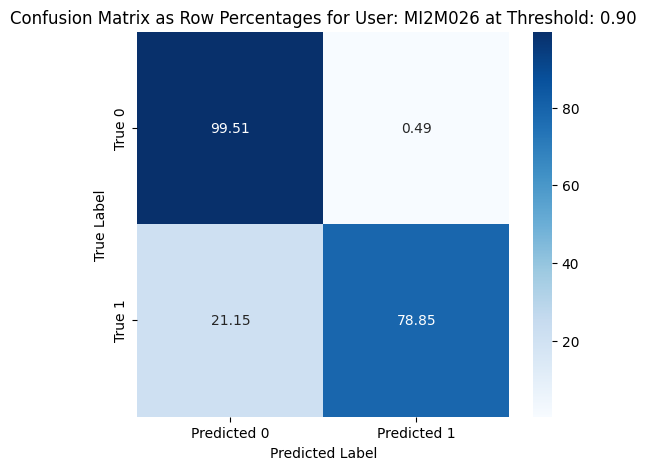

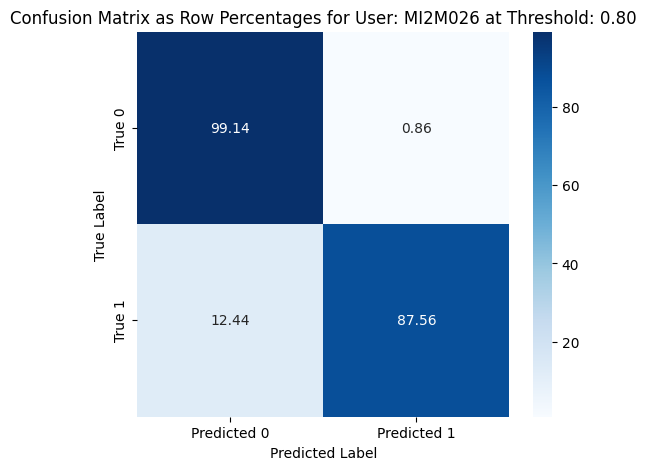

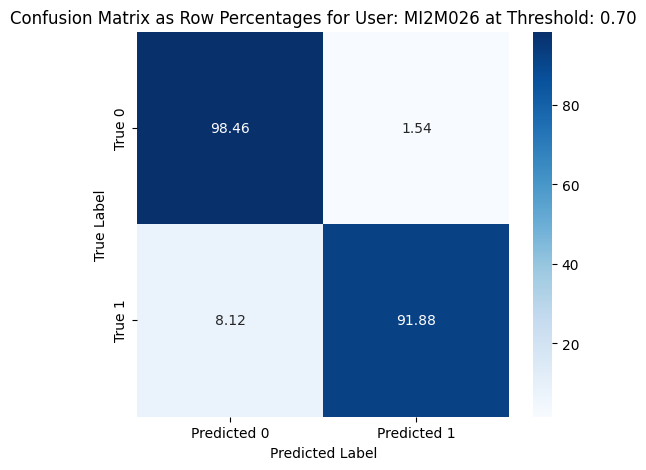

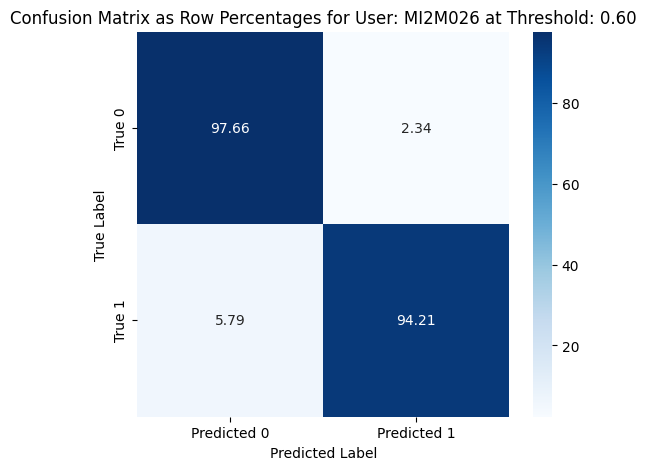

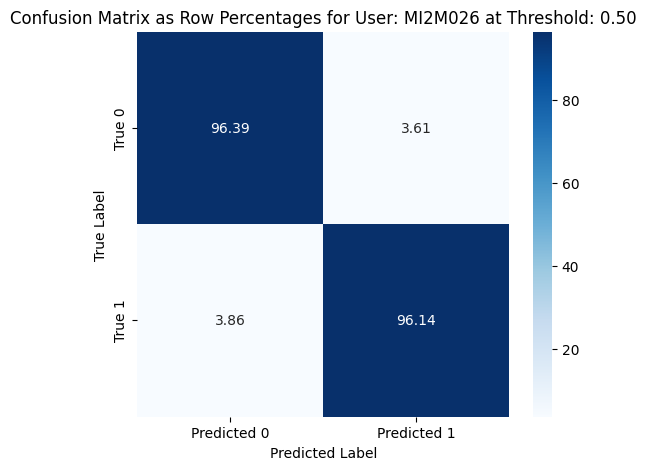

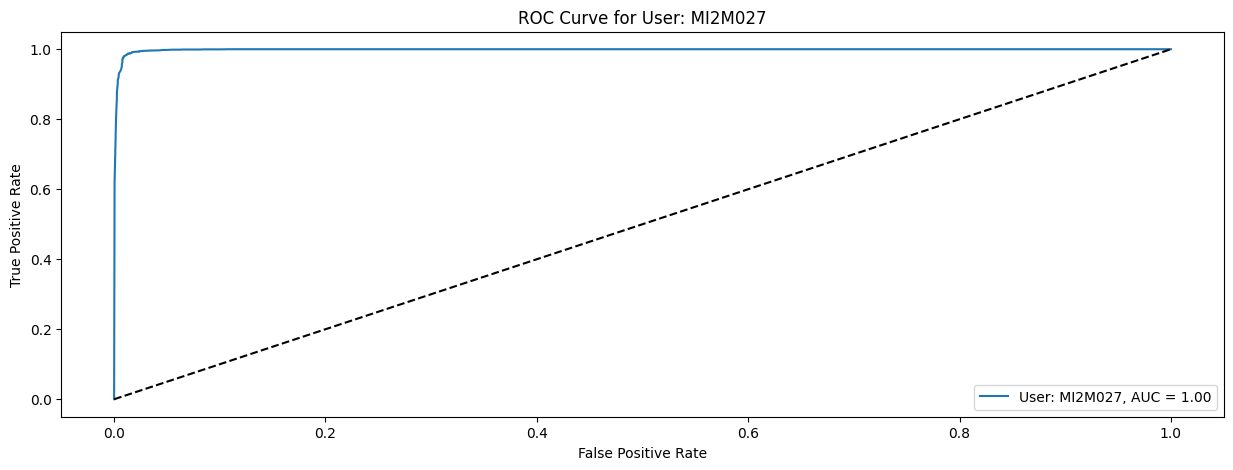

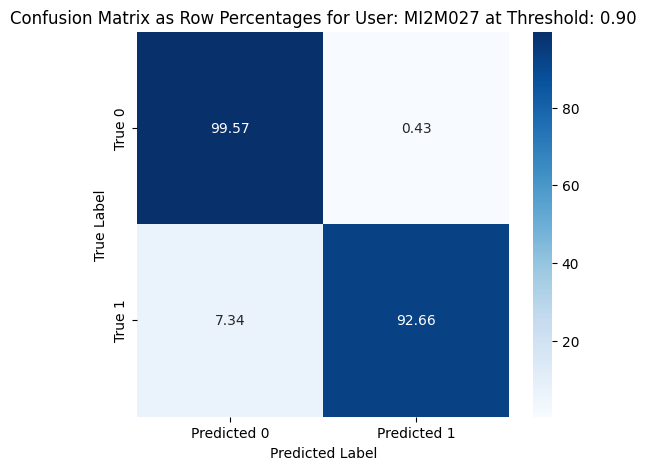

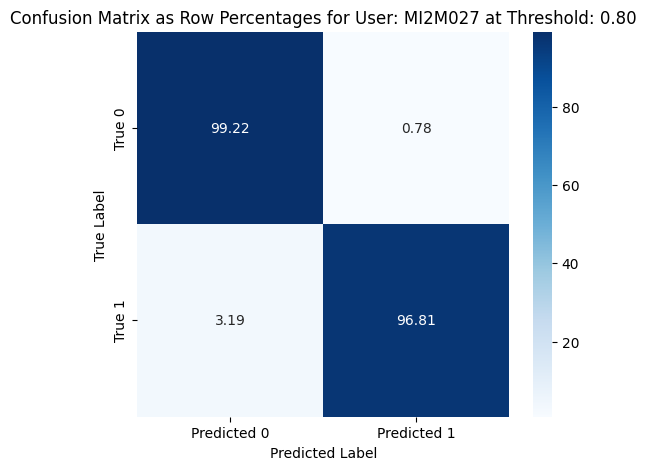

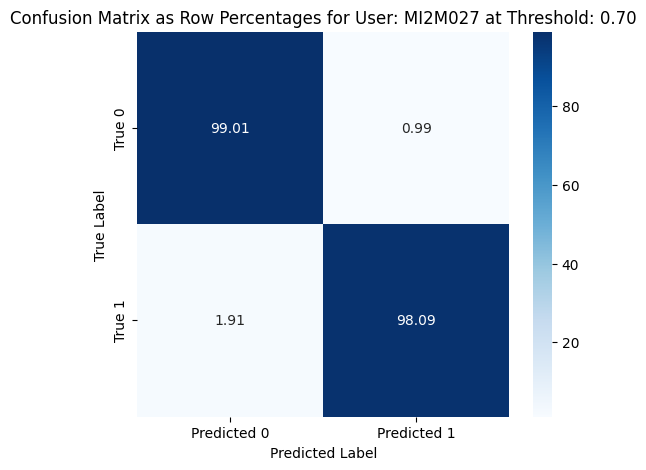

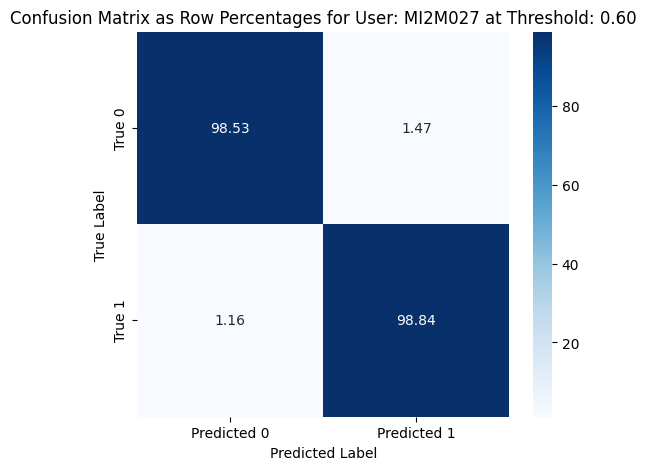

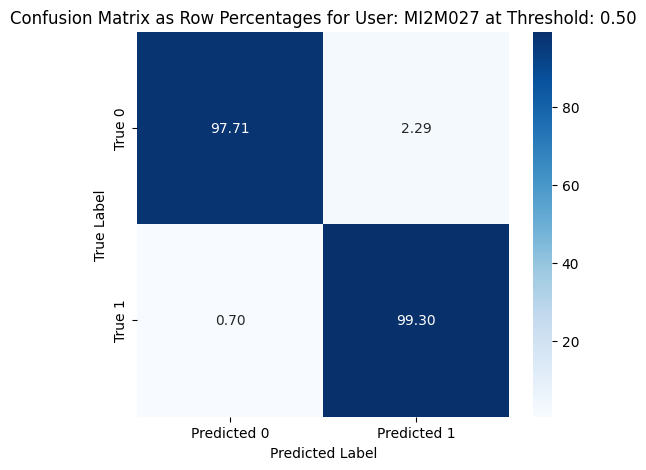

In [262]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

windowed_data = pd.read_csv('Empatica data.csv')
unique_users = windowed_data['user'].unique()

for user in unique_users:
    user_data = windowed_data[windowed_data['user'] == user].copy()
    user_data = user_data.drop(['documentation_day','user'], axis=1)

# Convert 'med' to binary if necessary - in our trial, a high dose (med=2) indicates that the physician deemed the regular dose (med=1) insufficiently effective.
    if user_data['med'].nunique() == 3:
        user_data['med'] = user_data['med'].replace({1: 0, 2: 1})

    # Split the data into features and target
    X = user_data.drop('med', axis=1)
    y = user_data['med']

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Train a simple Random Forest model
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)

    # Predict probabilities for the test set
    y_pred_proba = rf.predict_proba(X_test)[:, 1]

    # Calculate ROC curve and AUC score
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    # Plot the AUC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'User: {user}, AUC = {auc_score:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for User: {user}')
    plt.legend(loc='lower right')
    plt.show()


    # Generate and plot heatmaps for each threshold
    for threshold in [0.9,0.8,0.7,0.6, 0.5]:
        # Binarize predictions based on the threshold
        y_pred = (y_pred_proba >= threshold).astype(int)

        # Calculate TP, FP, TN, FN
        tp = ((y_pred == 1) & (y_test == 1)).sum()
        fp = ((y_pred == 1) & (y_test == 0)).sum()
        tn = ((y_pred == 0) & (y_test == 0)).sum()
        fn = ((y_pred == 0) & (y_test == 1)).sum()
        
        # Calculate row-wise percentages
        true_0_total = tn + fp
        true_1_total = fn + tp
        conf_matrix_percent = [
            [tn / true_0_total * 100 if true_0_total > 0 else 0, fp / true_0_total * 100 if true_0_total > 0 else 0],
            [fn / true_1_total * 100 if true_1_total > 0 else 0, tp / true_1_total * 100 if true_1_total > 0 else 0]
        ]

        # Plot heatmap
        plt.figure(figsize=(6, 5))
        sns.heatmap(conf_matrix_percent, annot=True, fmt=".2f", cmap="Blues",
                    xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["True 0", "True 1"])
        plt.title(f'Confusion Matrix as Row Percentages for User: {user} at Threshold: {threshold:.2f}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()


# 2. Pre-GNN Consolidated Weekly Graphs of Observational Data <a class="anchor" id="2"></a>


In [263]:
users_daily = pd.read_csv('users_daily.csv')
users_daily = users_daily.drop(['rec_num_acc', 'gx_mean', 'gy_mean', 'gz_mean',
       'gx_std', 'gy_std', 'gz_std', 'gx_zcr', 'gy_zcr', 'gz_zcr', 'g_rms',
       'rec_num_gyro', 'hrv_std', 'rec_num_hrv'],axis=1)
users_daily = users_daily.rename(columns={"hrv_mean":"hrv"})
users_daily

time_since_med    x_mean    y_mean    z_mean     x_std     y_std  \
0           1.072683 -1.498744 -9.448413  0.772515  0.830578  0.973898   
1           1.097683  0.703077 -1.441178  9.462996  1.327463  1.782649   
2           1.281017  4.575934 -2.133391  6.938239  1.776041  4.004590   
3           1.289350  3.061260  2.914816  8.572027  0.530262  0.823875   
4           1.297683  0.783691  1.888943  9.318151  0.945952  0.670448   
...              ...       ...       ...       ...       ...       ...   
7247        5.269743 -3.269225 -5.665593  7.675982  1.473115  2.074023   
7248        5.303077  4.080318 -6.497414  6.116287  0.048586  0.139220   
7249        5.419743  6.069656 -3.436832  6.646038  0.719978  0.491318   
7250        5.486410  5.760258 -4.566604  6.427857  0.057020  0.175552   
7251        5.536410  2.189869 -8.898009 -3.190645  3.758921  2.363271   

         z_std       rms         hrv         user  day   date  
0     3.342419  5.541225  111.894697  yaron_week1    1   2.05  
1     1.373751  5.541348  258.673451  yaron_week1    1   2.05  
2     1.959975  4.954112  101.867631  yaron_week1    1   2.05  
3     0.556614  5.518065  103.328085  yaron_week1    1   2.05  
4     0.803883  5.507880  105.621076  yaron_week1    1   2.05  
...        ...       ...         ...          ...  ...    ...  
7247  3.566134  5.822585    0.715439   elad_week1    5  30.90  
7248  0.147121  5.664932    0.732512   elad_week1    5  30.90  
7249  0.789779  5.562444    0.681217   elad_week1    5  30.90  
7250  0.093944  5.637724    0.964479   elad_week1    5  30.90  
7251  1.979228  5.602092    0.598494   elad_week1    5  30.90  

[7252 rows x 12 columns]

In [264]:
trial_data = pd.read_csv('Empatica data.csv')


In [265]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

target_column = 'med'  
exclude_columns = ['documentation_day', 'user']  


X_train = trial_data.drop(columns=['documentation_day', 'user', 'med']  )
y_train = trial_data[target_column]

X_test = users_daily.drop(columns=['time_since_med', 'user','date', 'day'])
#y_test = df2[target_column]

# Initialize the Random Forest classifier
rf = RandomForestClassifier()

# Train the model on df1
rf.fit(X_train, y_train)

# Predict probabilities on df2
y_pred_proba = rf.predict_proba(X_test)[:, 1]  # get probability of class 1
users_daily['predicted_proba'] = y_pred_proba



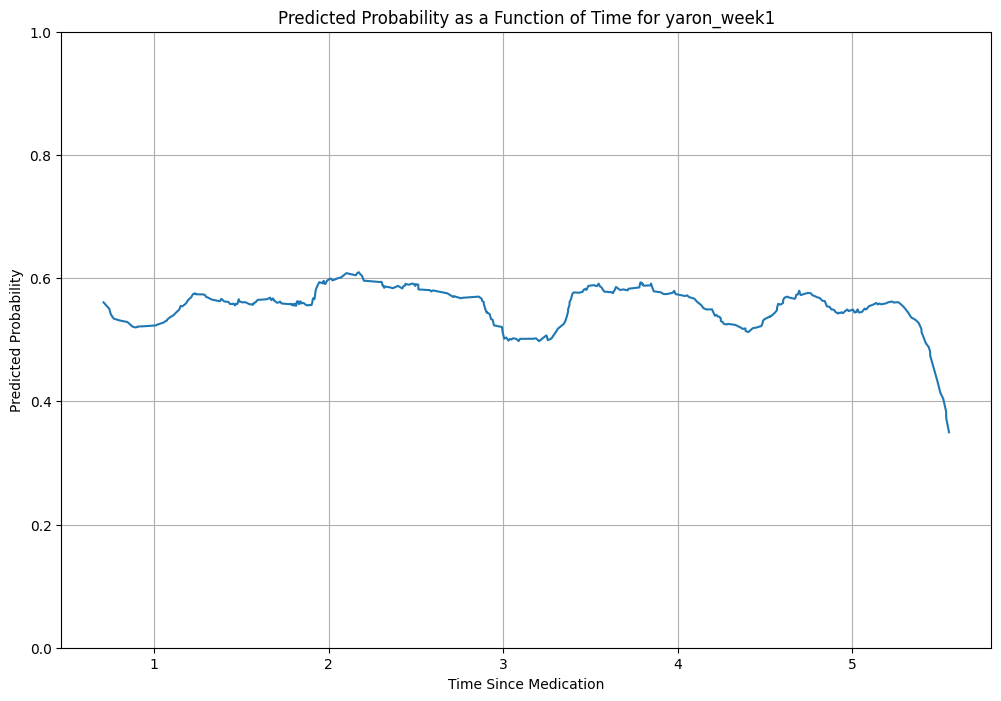

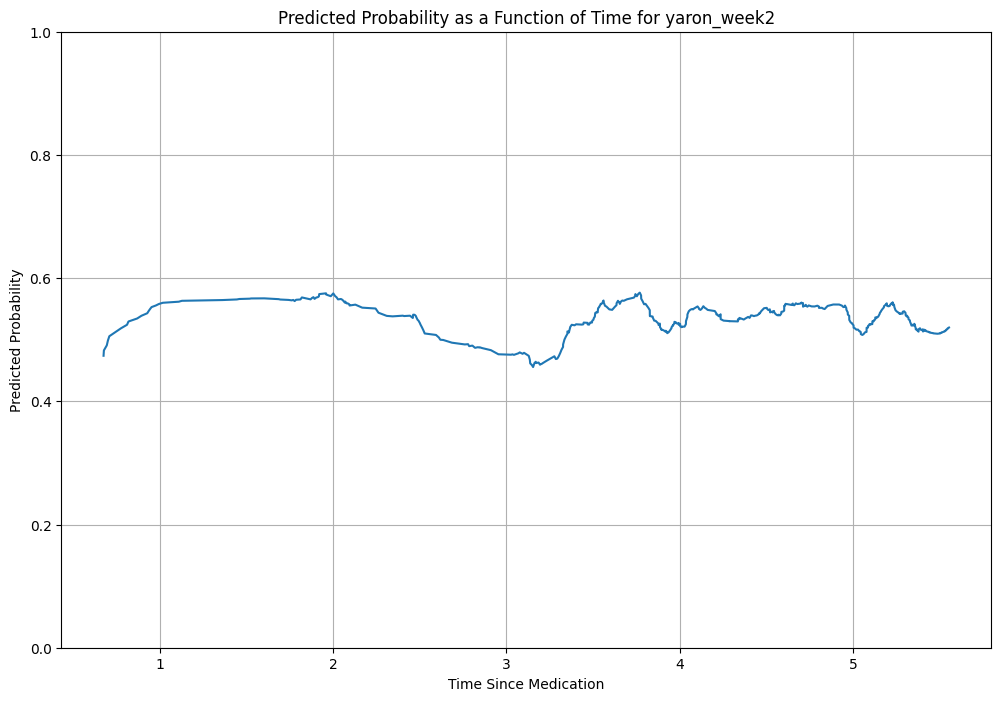

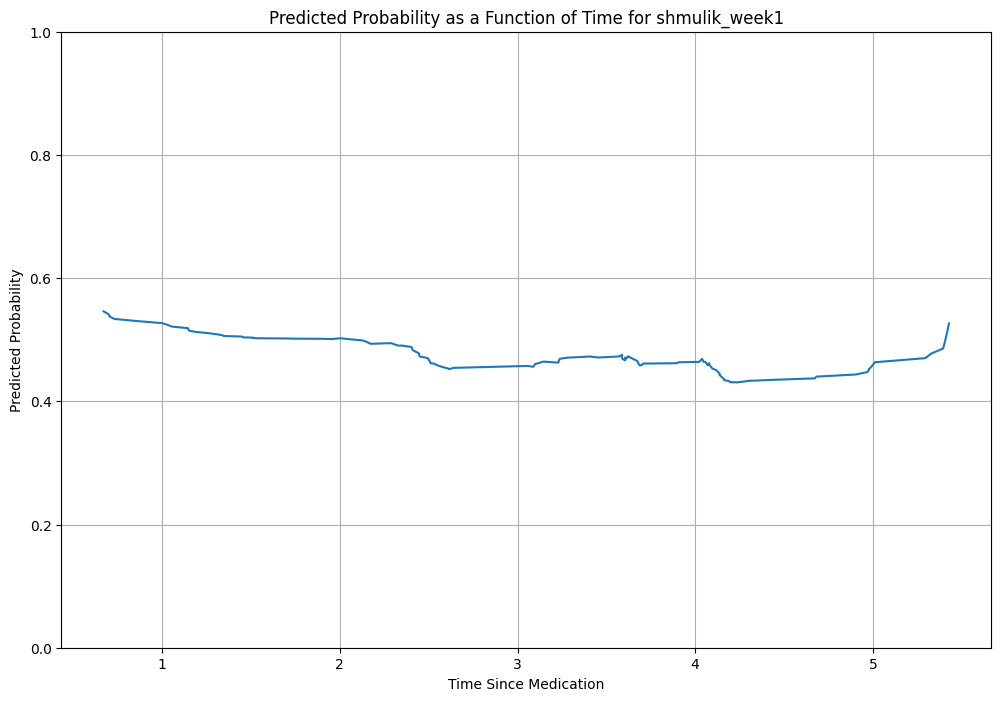

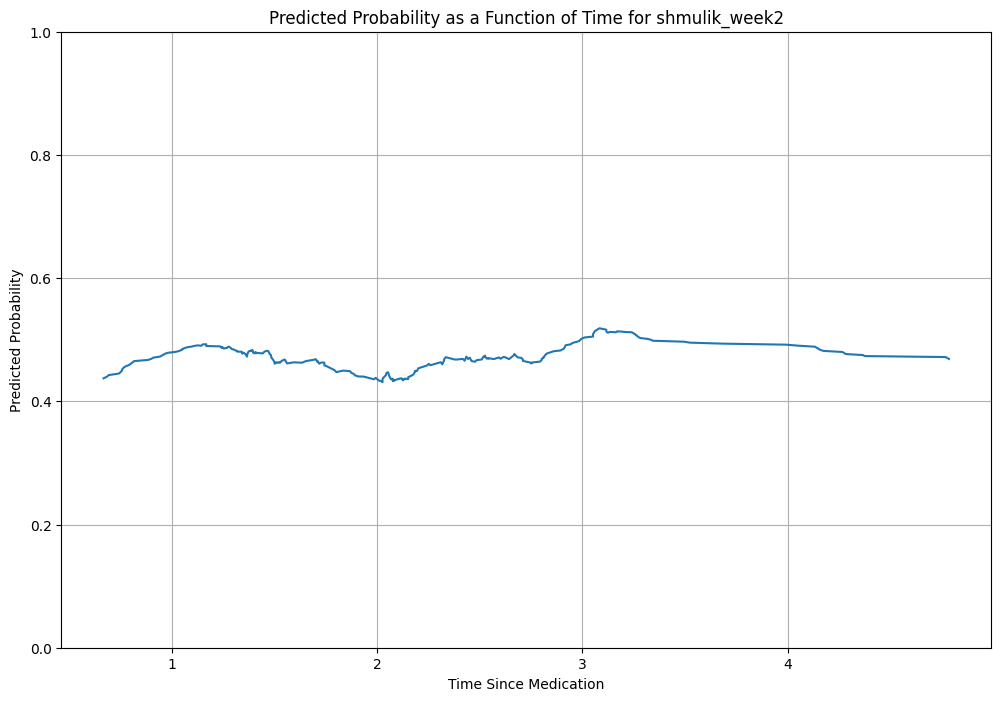

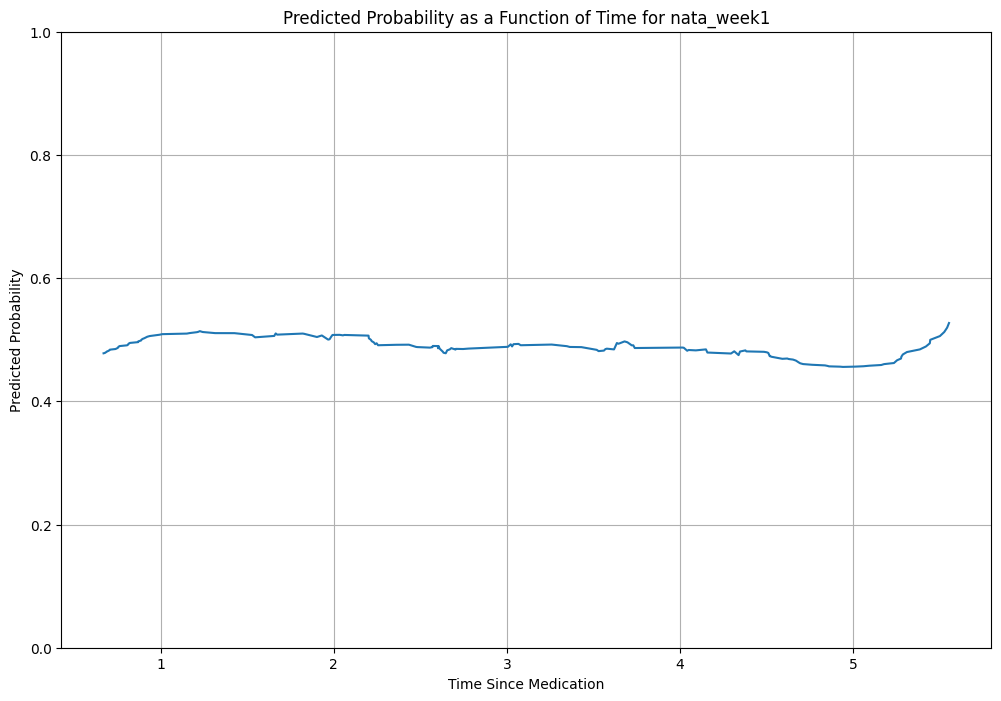

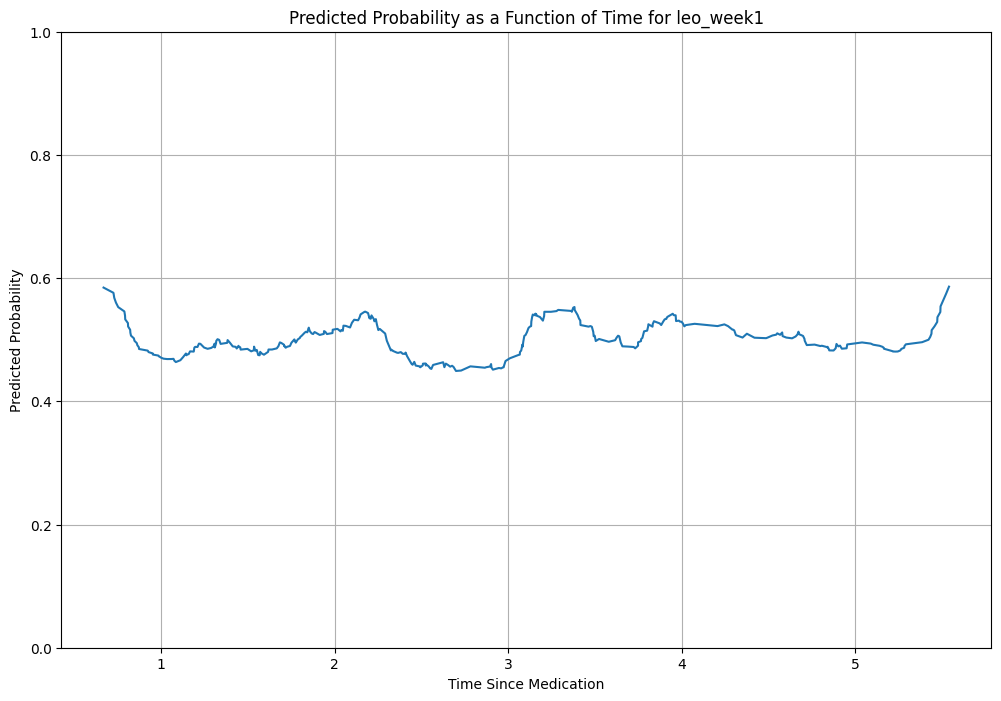

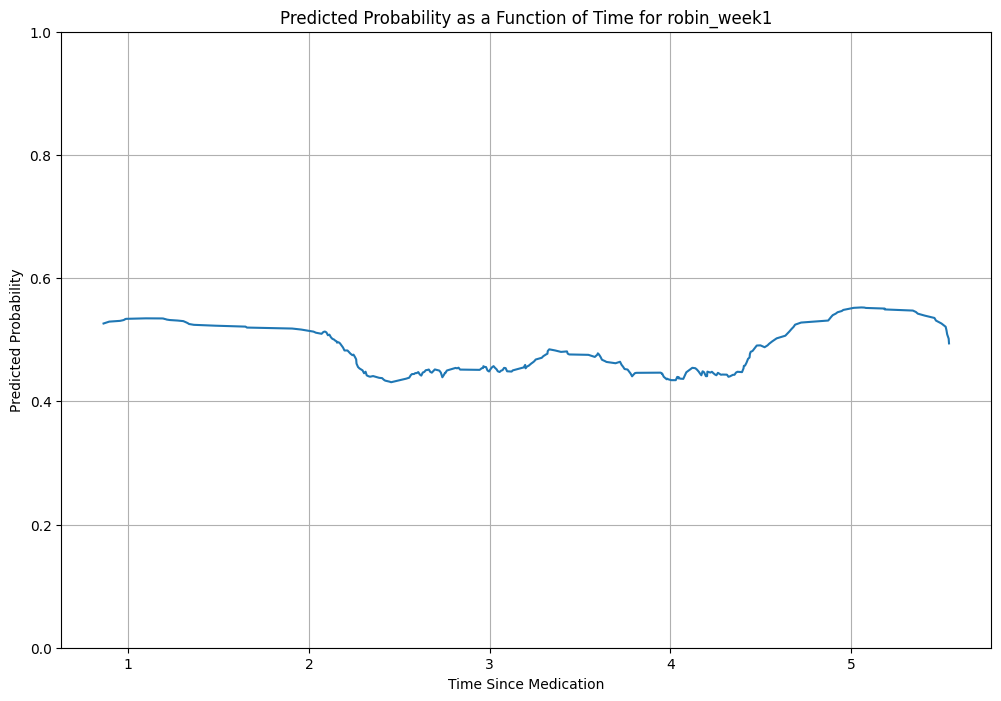

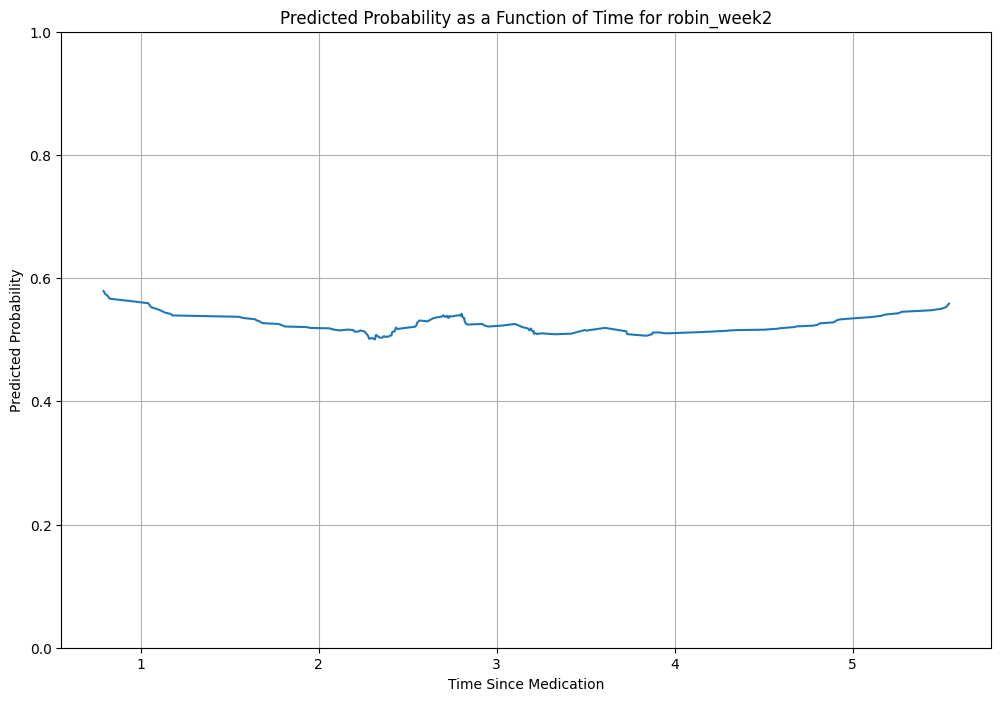

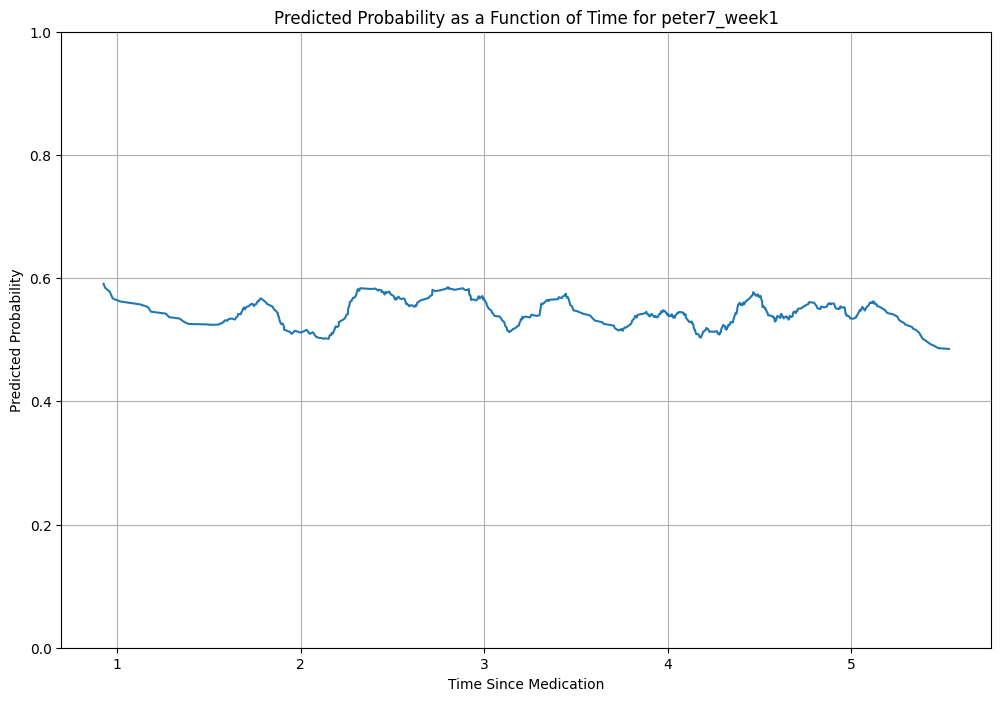

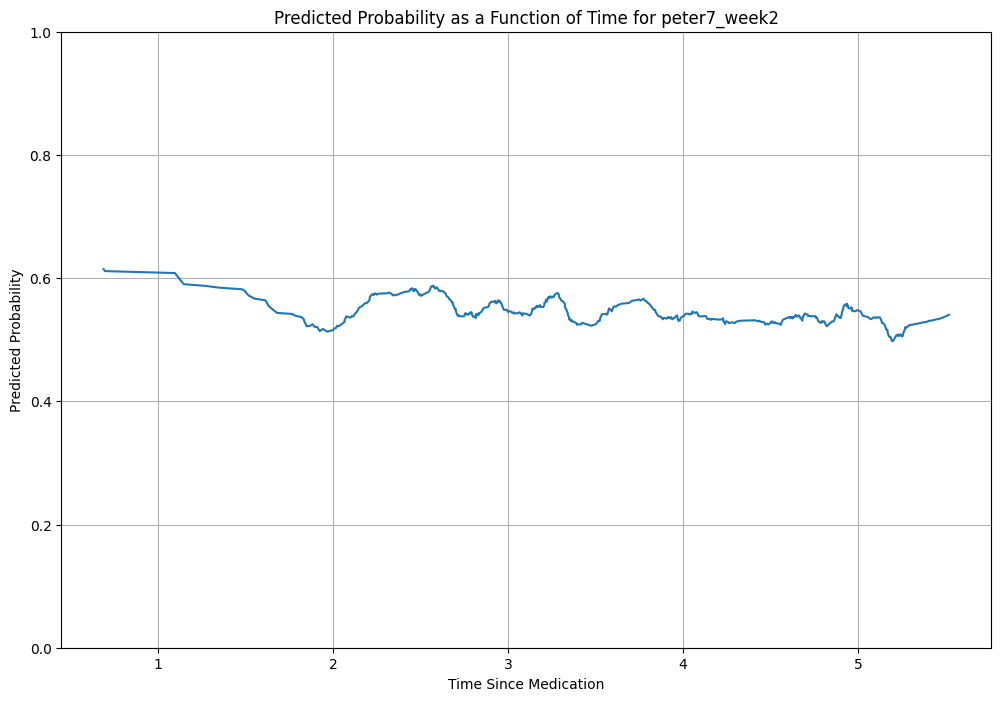

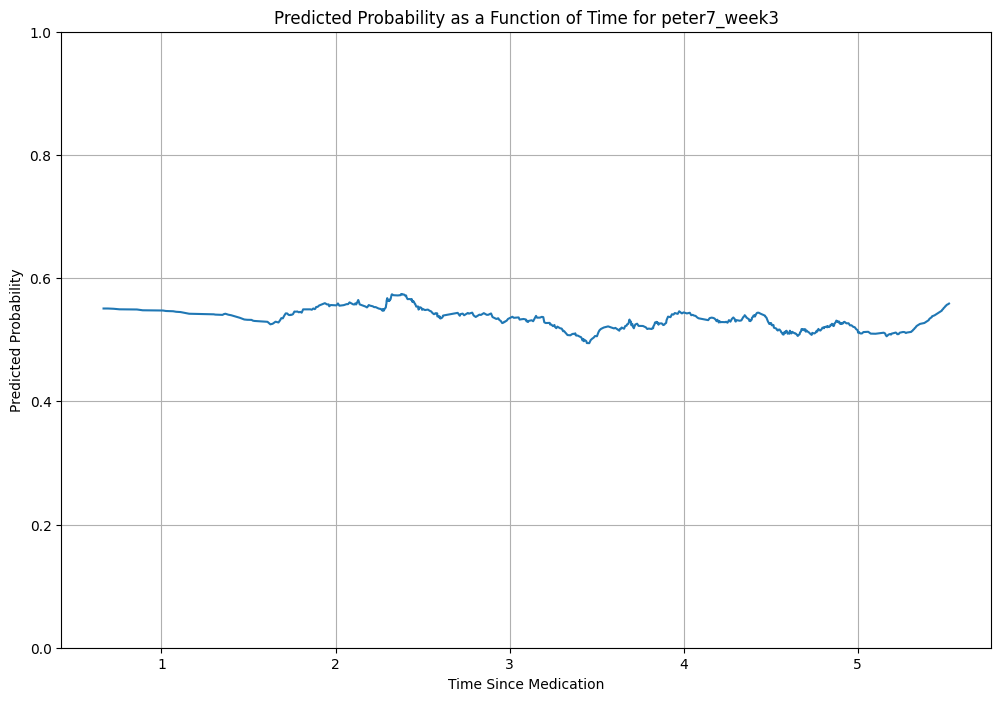

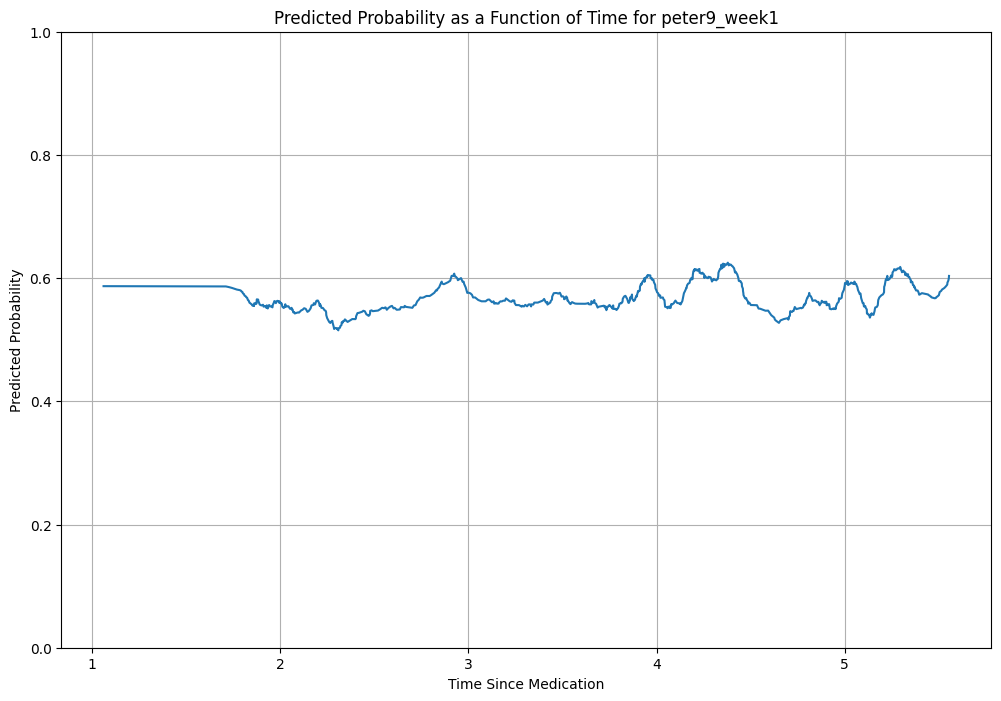

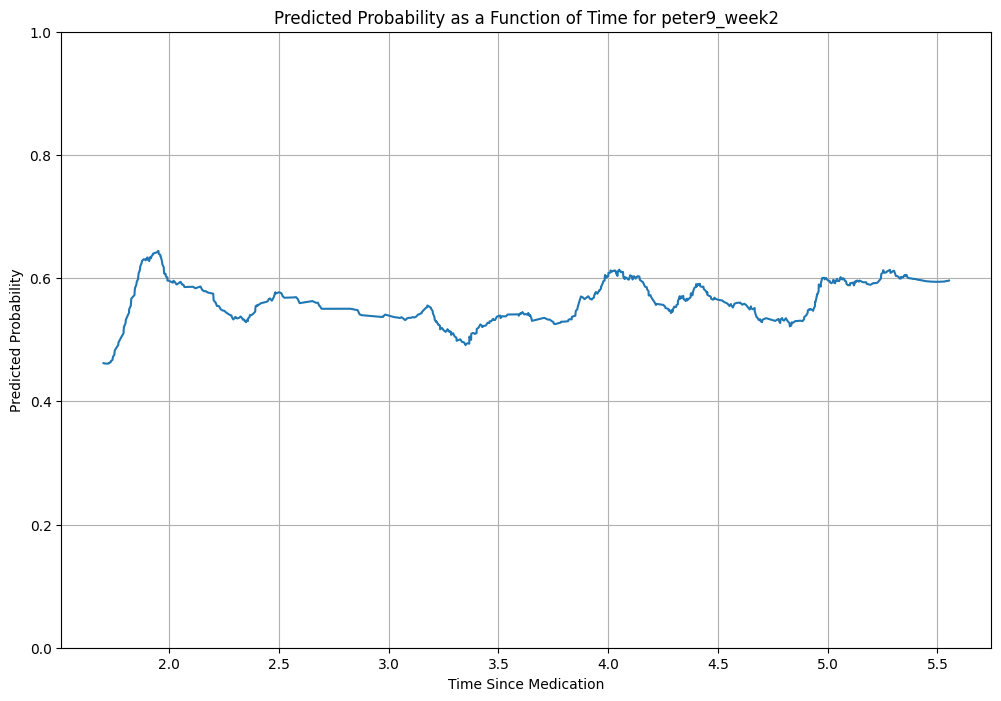

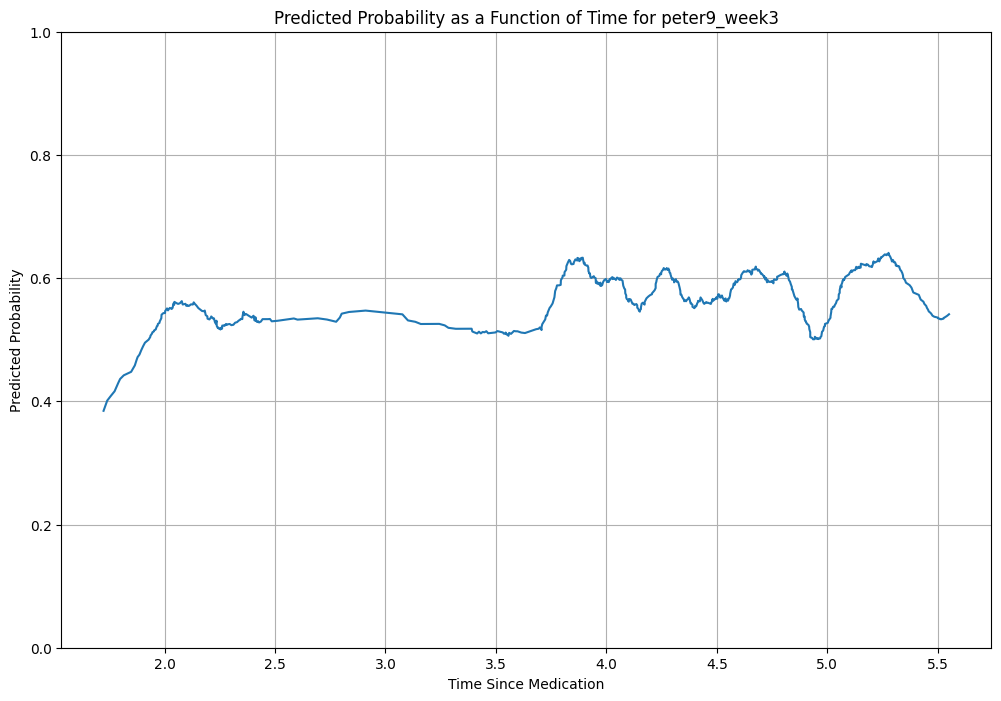

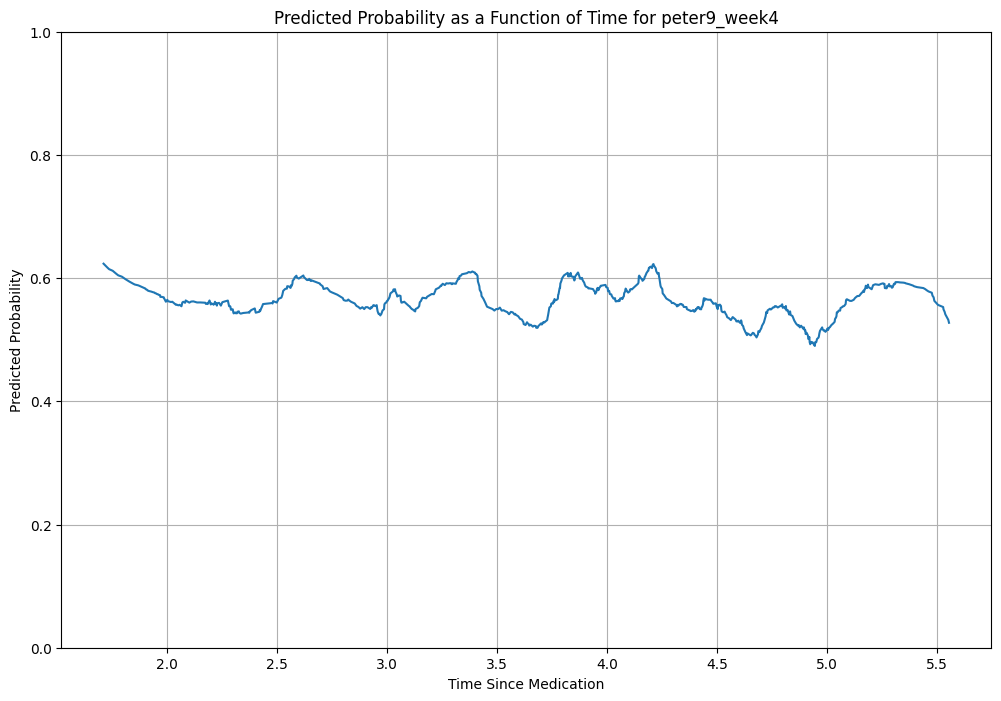

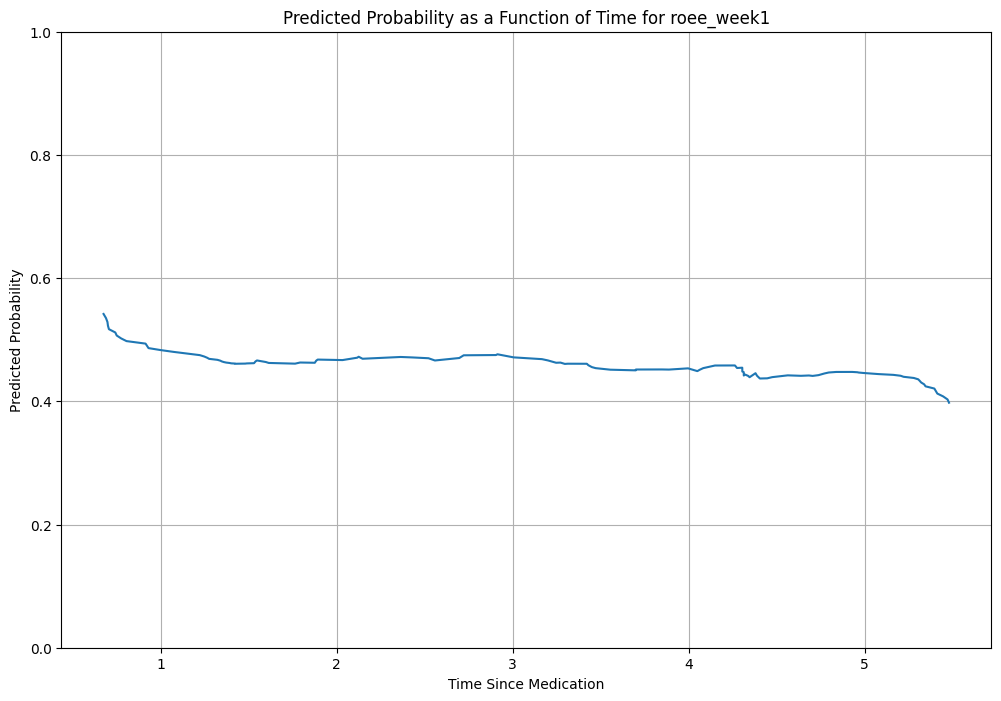

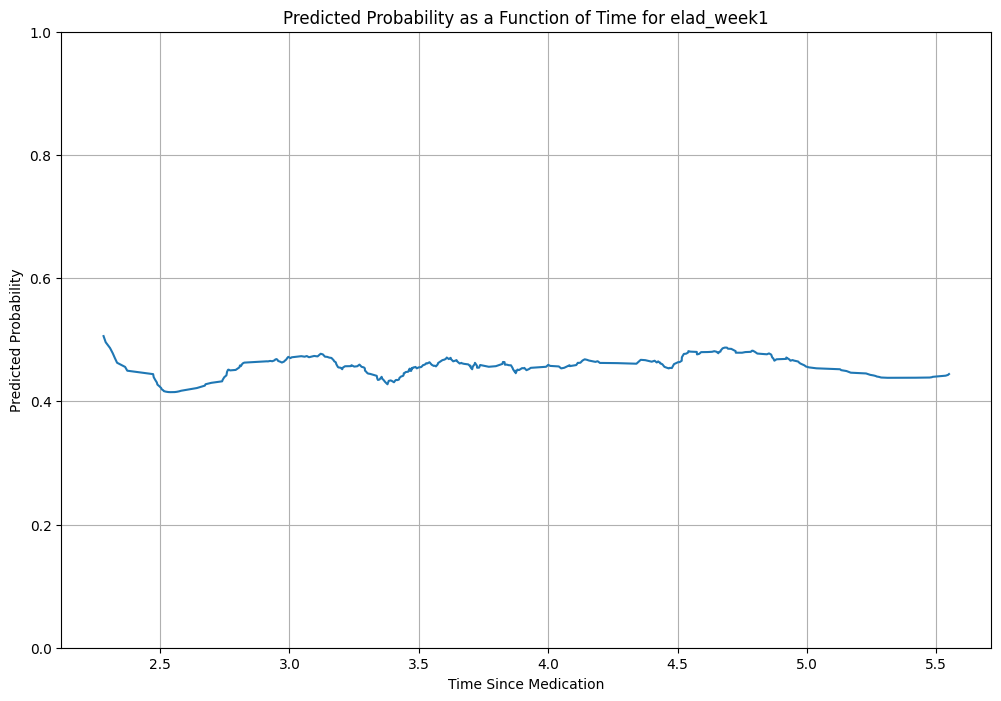

In [266]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

users = users_daily["user"].unique()

for user in users:
    df_filtered = users_daily[users_daily["user"] == user].sort_values(by='time_since_med')
    x = df_filtered['time_since_med']
    y = df_filtered['predicted_proba']
    plt.figure(figsize=(12, 8))
    y_savgol = savgol_filter(y, window_length=67, polyorder=3)
    plt.plot(x, y_savgol)
    plt.xlabel('Time Since Medication')
    plt.ylabel('Predicted Probability')
    plt.ylim(0, 1)
    plt.title(f'Predicted Probability as a Function of Time for {user}')
    plt.grid(True)
    plt.show()


# 3.GNN <a class="anchor" id="3"></a>


In [293]:
trial_data = pd.read_csv('Empatica data.csv')
trial_data['user'] = trial_data['user'] + '_' + trial_data['med'].astype(str)
trial_data['user'] =trial_data['user'] + '_' + trial_data['documentation_day'].astype(str)
unique_users = trial_data['user'].unique()
node1 =[]
node2 = []
y = []
for user in unique_users:
    windowed_data = trial_data[trial_data['user'] == user]
    first_index = windowed_data.index[0]
    last_index = windowed_data.index[-1]
    node1.append(first_index)
    node2.append(first_index+1)
    for i in range(first_index+1,last_index):
        node1.append(i)
        node2.append(i-1)
        node1.append(i)
        node2.append(i+1)
    node1.append(last_index)
    node2.append(last_index-1)
    print(user)
    print(f"start:{first_index}")
    print(f"end:{last_index}")
edge_list = torch.tensor([
                         node1, # Source Nodes
                         node2  # Target Nodes
                        ], dtype=torch.long)

MI2M014_0_1
start:0
end:9913
MI2M014_1_2
start:9914
end:17072
MI2M015_0_1
start:17073
end:17265
MI2M015_0_2
start:17266
end:18558
MI2M015_0_3
start:18559
end:21256
MI2M015_0_4
start:21257
end:22291
MI2M015_0_5
start:22292
end:28374
MI2M015_0_6
start:28375
end:28567
MI2M015_1_7
start:28568
end:36247
MI2M017_0_1
start:36248
end:45740
MI2M017_1_2
start:45741
end:54728
MI2M020_0_1
start:54729
end:55560
MI2M020_0_2
start:55561
end:58031
MI2M020_0_3
start:58032
end:63745
MI2M020_1_4
start:63746
end:67115
MI2M020_1_5
start:67116
end:68975
MI2M023_0_1
start:68976
end:76461
MI2M023_1_2
start:76462
end:84851
MI2M024_0_1
start:84852
end:87701
MI2M024_0_2
start:87702
end:90064
MI2M024_0_3
start:90065
end:92781
MI2M024_1_4
start:92782
end:103444
MI2M025_0_1
start:103445
end:106074
MI2M025_0_2
start:106075
end:112602
MI2M025_1_3
start:112603
end:119857
MI2M026_0_1
start:119858
end:130548
MI2M026_1_2
start:130549
end:140855
MI2M027_0_1
start:140856
end:143023
MI2M027_0_2
start:143024
end:144287
MI2M0

In [294]:
y = trial_data["med"].values.tolist()

In [295]:
# List of features you want to extract
features = ['x_mean', 'y_mean', 'z_mean', 'x_std', 'y_std', 'z_std', 
            'rms', 'hrv']

# Extract the values for the specified features
nodes = trial_data[features].values.tolist()
node_features = torch.tensor(nodes,dtype=torch.long)
node_y = torch.tensor(y,dtype=torch.long)



In [296]:
from torch_geometric.utils.convert import to_networkx

data = Data(x=node_features, edge_index=edge_list, y=node_y)


" Print the graph info "
print("Number of nodes: ", data.num_nodes)
print("Number of edges: ",data.num_edges)
print("Number of features per node (Length of feature vector): ", data.num_node_features,"\n")
print("Number of weights per edge (edge-features): ", data.num_edge_features, "\n")

" Plot the graph "

G = to_networkx(data)
#nx.draw_networkx(G)


Number of nodes:  156619
Number of edges:  313174
Number of features per node (Length of feature vector):  8 

Number of weights per edge (edge-features):  0 



In [297]:
train_mask = torch.zeros(156619, dtype=torch.bool)
#train_mask[17073:103445] = True
train_mask[36248:] = True

test_mask = torch.zeros(156619, dtype=torch.bool)
test_mask[17073:36248] = True  #15

val_mask = torch.zeros(156619, dtype=torch.bool)
val_mask[0:17073] = True  #14


In [298]:
class OurNet(torch.nn.Module):
    def __init__(self):
        super(OurNet, self).__init__()
        hidden_channels = 8
        self.conv1 = GATConv(hidden_channels, hidden_channels, heads=2, concat=True)
        self.conv2 = GATConv(hidden_channels * 2, hidden_channels, heads=2, concat=True)
        self.conv3 = GATConv(hidden_channels * 2, 2, heads=1, concat=False)
        self.dropout = torch.nn.Dropout(p=0.4)

    def forward(self, x, edge_index):
        x = x.float()
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        embeddings = x
        x = self.conv3(x, edge_index)
        return embeddings, F.log_softmax(x, dim=1)
        
def train():
    model.train()
    optimizer.zero_grad()
    F.nll_loss(model(data.x, data.edge_index)[1][train_mask], data.y[train_mask]).backward()
    optimizer.step()

def test():
    model.eval()
    logits = model(data.x, data.edge_index)[1]
    accs = []
    for mask in [train_mask, val_mask, test_mask]:
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs


In [302]:
test_acc = 0
val_acc = 0
try_num = 0
while val_acc < 0.7:
    try_num += 1
    device = torch.device('cuda' if torch.cuda.is_available() and use_cuda_if_available else 'cpu')

    model, data = OurNet().to(device), data.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    
    
    best_val_acc = test_acc = 0
    for epoch in range(1,5):
        train()
        _, val_acc, tmp_test_acc = test()
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            test_acc = tmp_test_acc
        log = 'Epoch: {:03d}, Test: {:.4f}, Val: {:.4f}'
        
        if epoch % 1 == 0:
            print(log.format(epoch, test_acc, val_acc))
print(f"try number: {try_num}")

Epoch: 001, Test: 0.5904, Val: 0.2917
Epoch: 002, Test: 0.5918, Val: 0.3096
Epoch: 003, Test: 0.5920, Val: 0.3245
Epoch: 004, Test: 0.5922, Val: 0.3360
Epoch: 001, Test: 0.4998, Val: 0.2961
Epoch: 002, Test: 0.4998, Val: 0.2947
Epoch: 003, Test: 0.4998, Val: 0.2943
Epoch: 004, Test: 0.4998, Val: 0.2937
Epoch: 001, Test: 0.5987, Val: 0.5753
Epoch: 002, Test: 0.5987, Val: 0.5732
Epoch: 003, Test: 0.5987, Val: 0.5719
Epoch: 004, Test: 0.5987, Val: 0.5699
Epoch: 001, Test: 0.5146, Val: 0.3909
Epoch: 002, Test: 0.5106, Val: 0.3921
Epoch: 003, Test: 0.5059, Val: 0.3937
Epoch: 004, Test: 0.5009, Val: 0.3958
Epoch: 001, Test: 0.5995, Val: 0.5807
Epoch: 002, Test: 0.5995, Val: 0.5807
Epoch: 003, Test: 0.5995, Val: 0.5772
Epoch: 004, Test: 0.5995, Val: 0.5568
Epoch: 001, Test: 0.4005, Val: 0.4193
Epoch: 002, Test: 0.4005, Val: 0.4193
Epoch: 003, Test: 0.4005, Val: 0.4193
Epoch: 004, Test: 0.4005, Val: 0.4193
Epoch: 001, Test: 0.4132, Val: 0.3601
Epoch: 002, Test: 0.4132, Val: 0.3593
Epoch: 003, 

In [303]:
users_daily

time_since_med    x_mean    y_mean    z_mean     x_std     y_std  \
0           1.072683 -1.498744 -9.448413  0.772515  0.830578  0.973898   
1           1.097683  0.703077 -1.441178  9.462996  1.327463  1.782649   
2           1.281017  4.575934 -2.133391  6.938239  1.776041  4.004590   
3           1.289350  3.061260  2.914816  8.572027  0.530262  0.823875   
4           1.297683  0.783691  1.888943  9.318151  0.945952  0.670448   
...              ...       ...       ...       ...       ...       ...   
7247        5.269743 -3.269225 -5.665593  7.675982  1.473115  2.074023   
7248        5.303077  4.080318 -6.497414  6.116287  0.048586  0.139220   
7249        5.419743  6.069656 -3.436832  6.646038  0.719978  0.491318   
7250        5.486410  5.760258 -4.566604  6.427857  0.057020  0.175552   
7251        5.536410  2.189869 -8.898009 -3.190645  3.758921  2.363271   

         z_std       rms  rec_num_acc   gx_mean  ...        x7        x8  \
0     3.342419  5.541225          737  0.036052  ... -0.999997 -1.000000   
1     1.373751  5.541348          237 -0.012798  ... -0.999997 -1.000000   
2     1.959975  4.954112          152  0.074092  ... -0.997537 -1.000000   
3     0.556614  5.518065          241  0.005345  ... -0.997260 -1.000000   
4     0.803883  5.507880          146  0.018580  ... -0.997503 -1.000000   
...        ...       ...          ...       ...  ...       ...       ...   
7247  3.566134  5.822585           42  0.014035  ... -0.857646 -0.992824   
7248  0.147121  5.664932           16 -0.000229  ... -0.895992 -0.994233   
7249  0.789779  5.562444           27 -0.018416  ... -0.952946 -0.994729   
7250  0.093944  5.637724           25 -0.006011  ... -0.976256 -0.995469   
7251  1.979228  5.602092           29 -0.052113  ... -0.980806 -0.994077   

            x9        x10       x11       x12       x13       x14        x15  \
0    -0.995403  31.859926 -1.000000 -1.000000 -1.000000 -0.870750  12.056167   
1    -0.995404  31.859966 -1.000000 -1.000000 -1.000000 -0.870752  12.056177   
2    -0.163268  11.974940 -1.000000 -0.998431 -1.000000 -0.698605   3.156089   
3    -0.138959  12.110806 -1.000000 -0.998463 -1.000000 -0.726130   3.447226   
4    -0.140366  12.176667 -1.000000 -0.998576 -1.000000 -0.725579   3.480818   
...        ...        ...       ...       ...       ...       ...        ...   
7247  1.107898  -0.959737 -0.730214 -0.153306 -0.894379 -0.833711  -0.788980   
7248  0.845541  -0.850937 -0.523761 -0.862953 -0.498989 -0.467392  -0.943998   
7249  0.313055  -0.773502 -0.604224 -0.814391 -0.763072  0.324809  -0.938730   
7250  0.054126  -0.733022 -0.636527 -0.797291 -0.818017  0.611897  -0.936232   
7251 -0.342980  -0.678166 -0.726175 -0.589731 -0.936556  1.181868  -0.905385   

            x16  
0     42.076839  
1     42.076824  
2     18.287807  
3     18.278517  
4     18.518076  
...         ...  
7247   2.791424  
7248   2.037675  
7249   2.672951  
7250   2.853237  
7251   3.530348  

[7252 rows x 42 columns]

In [304]:
unique_users = users_daily['user'].unique()
node1 =[]
node2 = []
for user in unique_users:
    windowed_data_user = users_daily[users_daily['user'] == user]
    unique_dates = windowed_data_user["date"].unique()
    for date in unique_dates:
        windowed_data_user_date = windowed_data_user[windowed_data_user["date"] == date]
        first_index = windowed_data_user_date.index[0]
        last_index = windowed_data_user_date.index[-1]
        node1.append(first_index)
        node2.append(first_index+1)
        for i in range(first_index+1,last_index):
            node1.append(i)
            node2.append(i-1)
            node1.append(i)
            node2.append(i+1)
        node1.append(last_index)
        node2.append(last_index-1)
        print(user, date)
        print(last_index)

new_edge_list = torch.tensor([
                         node1, # Source Nodes
                         node2  # Target Nodes
                        ], dtype=torch.long)

# List of features you want to extract
features = ['x_mean', 'y_mean', 'z_mean', 'x_std', 'y_std', 'z_std', 
            'rms', 'hrv']

# Extract the values for the specified features
nodes = users_daily[features].values.tolist()
new_node_features = torch.tensor(nodes,dtype=torch.long)

new_data = Data(x=new_node_features, edge_index=new_edge_list)


yaron_week1 2.05
59
yaron_week1 3.05
160
yaron_week1 5.05
178
yaron_week1 11.05
413
yaron_week2 24.05
505
yaron_week2 26.05
691
yaron_week2 7.06
733
yaron_week2 8.06
900
shmulik_week1 16.01
936
shmulik_week1 17.01
959
shmulik_week1 18.01
983
shmulik_week1 19.01
999
shmulik_week1 22.01
1028
shmulik_week2 23.01
1057
shmulik_week2 24.01
1186
shmulik_week2 25.01
1197
shmulik_week2 29.01
1216
shmulik_week2 30.01
1283
nata_week1 1.11
1324
nata_week1 2.11
1358
nata_week1 4.11
1396
nata_week1 6.11
1428
nata_week1 8.11
1451
leo_week1 24.01
1514
leo_week1 26.01
1554
leo_week1 2.02
1693
leo_week1 9.02
1719
leo_week1 10.02
1780
leo_week1 11.02
1830
robin_week1 13.01
1874
robin_week1 15.01
1894
robin_week1 16.01
1903
robin_week1 18.01
1919
robin_week1 23.01
2091
robin_week2 30.01
2101
robin_week2 24.03
2167
robin_week2 26.03
2203
robin_week2 27.03
2222
robin_week2 29.03
2251
peter7_week1 2.09
2419
peter7_week1 3.09
2610
peter7_week1 4.09
2696
peter7_week1 5.09
2886
peter7_week2 6.09
3104
peter7_wee

KeyError: "['hrv'] not in index"

In [305]:
# get the new embedding for daily data
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    embeddings, _ = model(new_data.x, new_data.edge_index)
tensor_np = embeddings.cpu().detach().numpy()  # Convert tensor to NumPy array if it's still on GPU
users_daily = pd.read_csv('users_daily.csv')
# Define the new feature names for the tensor columns
new_features = [f'x{i+1}' for i in range(tensor_np.shape[1])]

# Ensure the dataframe and tensor have the same number of rows
if users_daily.shape[0] != tensor_np.shape[0]:
    print(f"Error: DataFrame has {users_daily.shape[0]} rows, but the tensor has {tensor_np.shape[0]} rows.")
else:
    # Add the tensor data as new columns to the dataframe
    users_daily[new_features] = tensor_np
    print("New features added successfully!")


New features added successfully!


In [306]:
# get the new embedding for trial data

model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    embeddings, _ = model(data.x, data.edge_index)
tensor_np = embeddings.cpu().detach().numpy()  # Convert tensor to NumPy array if it's still on GPU

# Define the new feature names for the tensor columns
new_features = [f'x{i+1}' for i in range(tensor_np.shape[1])]

# Ensure the dataframe and tensor have the same number of rows
if trial_data.shape[0] != tensor_np.shape[0]:
    print(f"Error: DataFrame has {trial_data.shape[0]} rows, but the tensor has {trial_data.shape[0]} rows.")
else:
    # Add the tensor data as new columns to the dataframe
    trial_data[new_features] = tensor_np
    print("New features added successfully!")


trial_data['user'] = trial_data['user'].str[:-4]


New features added successfully!


# 4. Post-GNN Evaluation of Trial Data <a class="anchor" id="4"></a>


### 4.1 LDA <a class="anchor" id="4.1"></a>


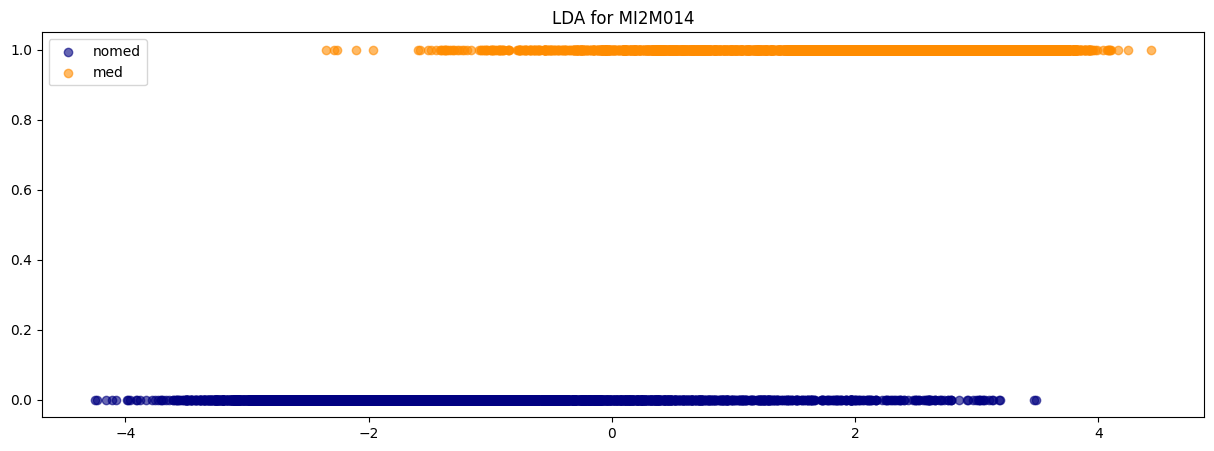

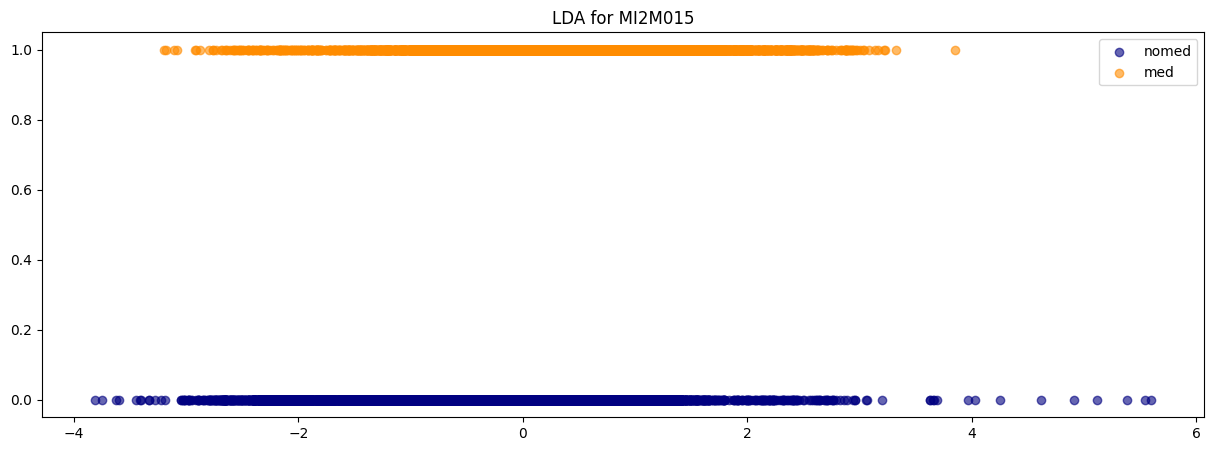

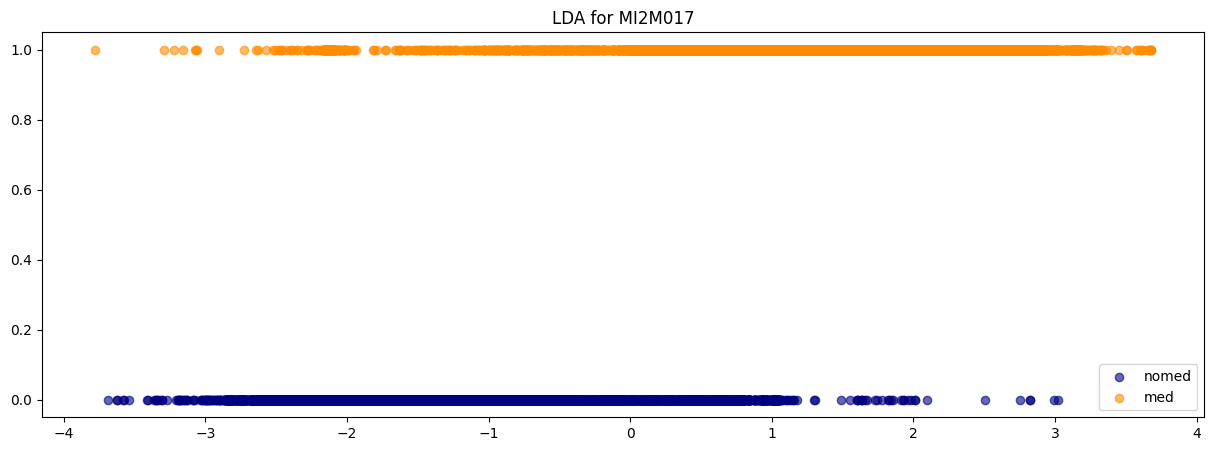

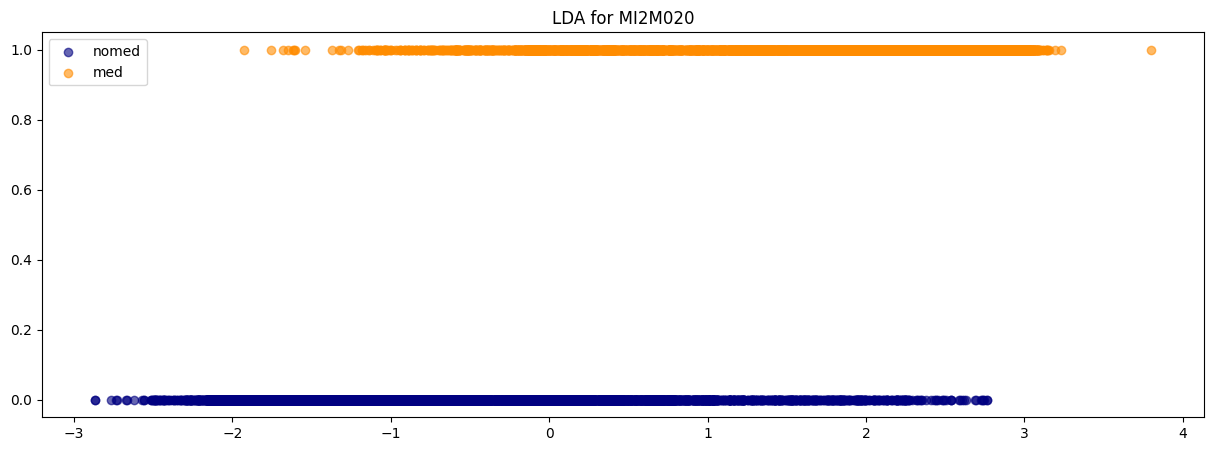

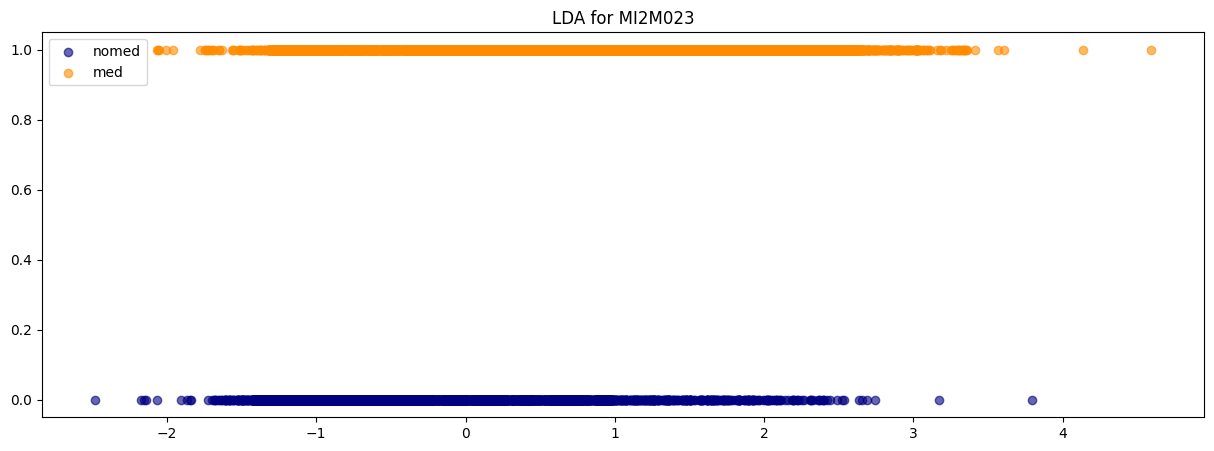

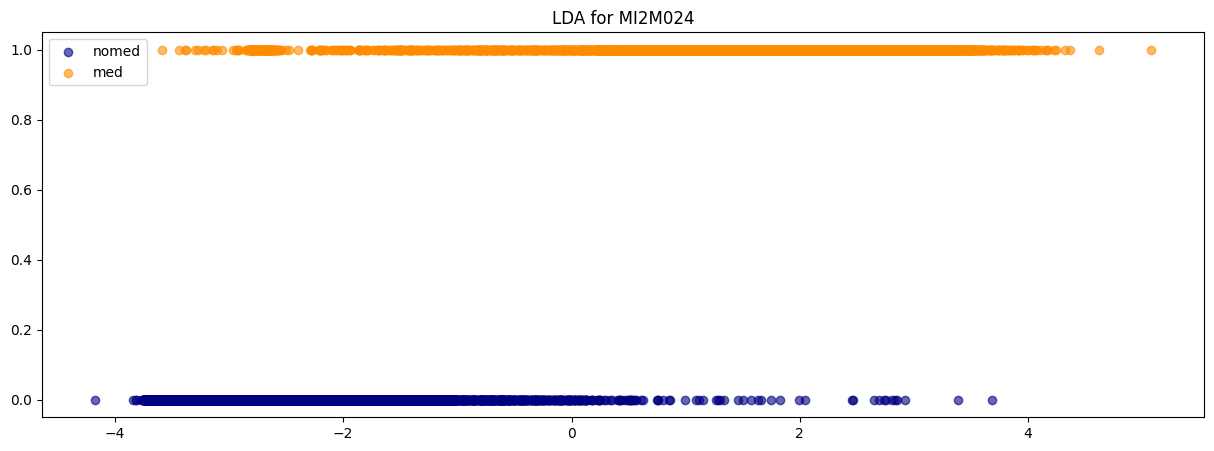

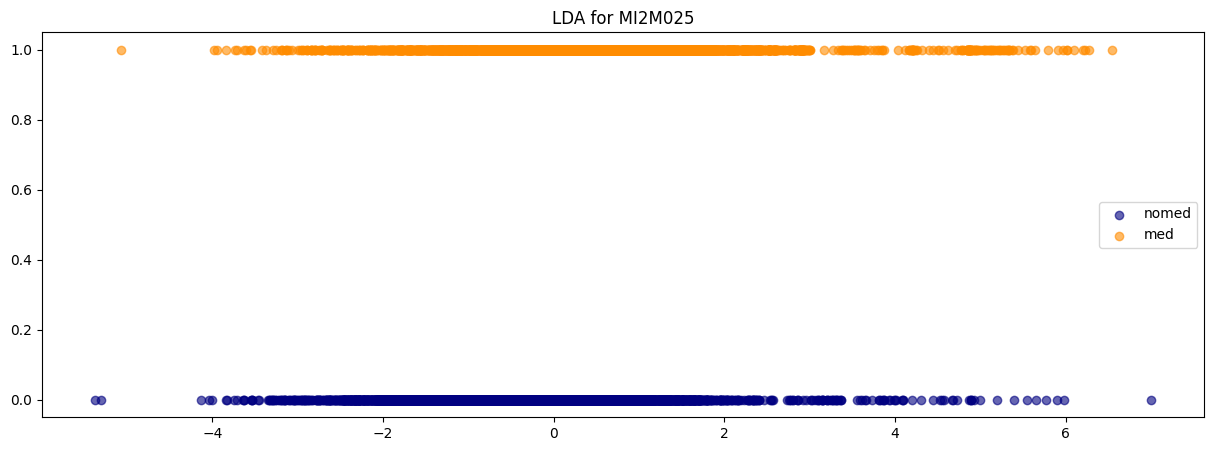

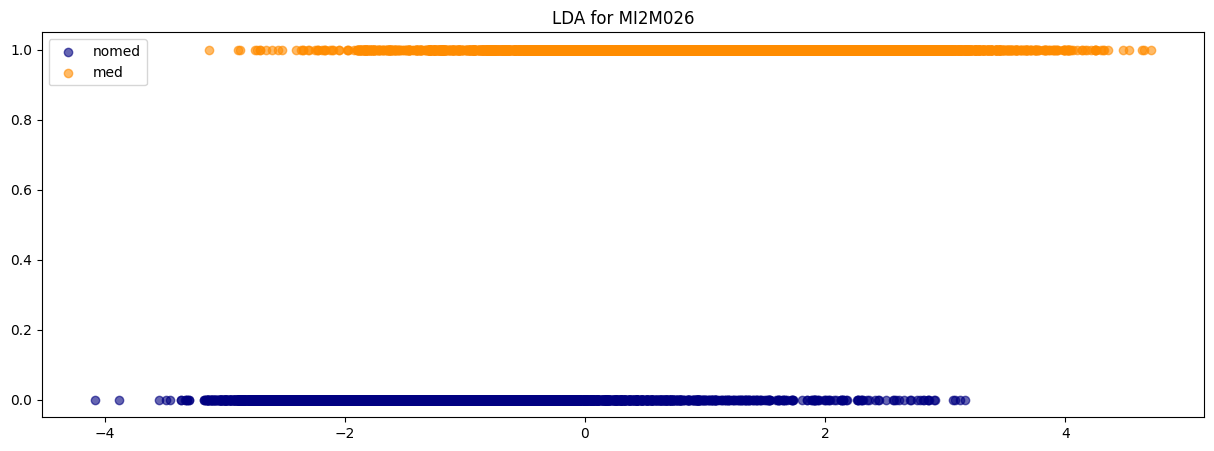

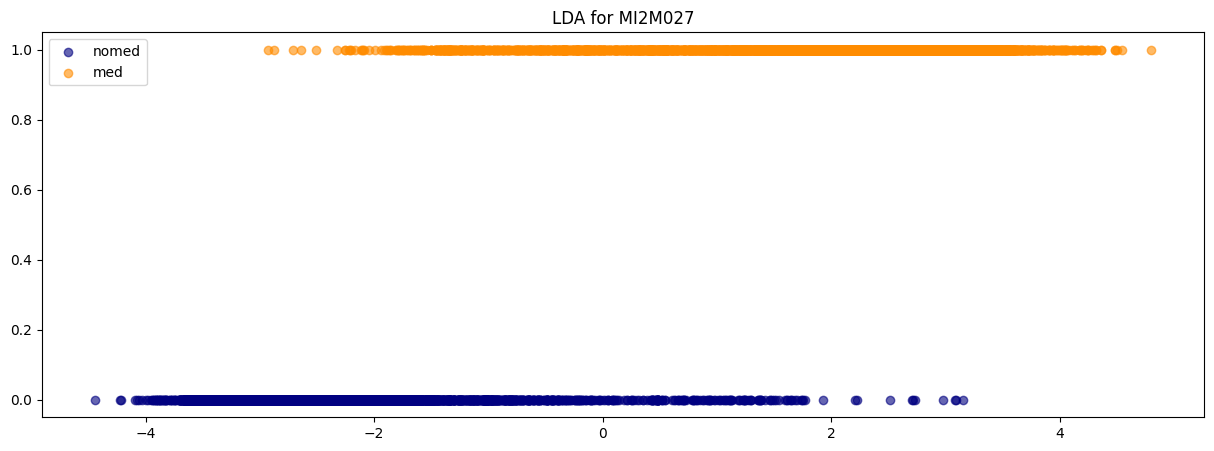

In [307]:
unique_users = trial_data['user'].unique()
for user in unique_users:
    med_status = {"nomed": 0,"med": 1}
    windowed_data = trial_data[trial_data['user'] == user]
    windowed_data = windowed_data.drop(columns=['documentation_day', 'user','x_mean', 'y_mean', 'z_mean', 'x_std', 'y_std', 'z_std', 
            'rms', 'hrv']  )
    windowed_data.rename(columns={'med':'target'}, inplace=True)
    X_train = windowed_data.drop(['target'],axis=1).reset_index()
    Y_train = windowed_data['target'].reset_index()
    optional_med_status = np.array([0,1])
    if optional_med_status.shape[0] == 2:
        lda_dim = 1
    elif optional_med_status.shape[0] < 2:
        print('fail: not enough status for med analysis')
    else:
        lda_dim = 2
    X_train = X_train.drop(['index'],axis=1)
    X_r = X_train.values
    y   = Y_train['target'].values
    target_names = np.array(["nomed", "med"])
    
    
    if lda_dim == 2:
        lda = LinearDiscriminantAnalysis(n_components=2)
        X_r2 = lda.fit(X_r, y).transform(X_r)
        df = pd.DataFrame({'lda_value1':X_r2[:,0],'lda_value2':X_r2[:,1],'Label':y})
    
        colors = ["navy", "darkorange","cyan"]
        plt.figure()
        for color, i, target_name in zip(colors, list(optional_med_status), target_names):
            plt.scatter(
                X_r2[y == i,0], X_r2[y == i,1], alpha=0.6, color=color, label=target_name
            )
        plt.legend(loc="best", shadow=False, scatterpoints=1)
        plt.title("LDA all states")
        plt.savefig(save_path + 'lda.png')
        plt.show()
        
        sil_score = []
        p_value   = []
        x1 = X_train.values[y==0]
        for stat in optional_med_status:
            if stat ==0:
                continue
            x2 = X_train.values[y==stat]
            x3 = np.concatenate((x1,x2),axis=0)
            sil_score.append(metrics.silhouette_score(x3,lda.predict(x3),metric='euclidean'))
            p_value.append(stats.ttest_ind(a=X_r2[y==0,0],b=X_r2[y==i,0],equal_var=False))
            
        X_r = X_train.values
        y   = Y_train['target'].values
        lda = LinearDiscriminantAnalysis(n_components=2)
        X_r2 = lda.fit(X_r, y).transform(X_r)
        without_center = [X_r2[y == 0,0].mean(), X_r2[y == 0,1].mean()]
        colors = ["darkorange",'cyan']
        plt.figure()
        for color, i, target_name in zip(colors, [1,2], target_names[1:]):
            plt.scatter(
                X_r2[y == i,0] - without_center[0], X_r2[y == i,1] - without_center[1], alpha=0.6, color=color, label=target_name
            )
        plt.legend(loc="best", shadow=False, scatterpoints=1)
        plt.title("LDA Aligned")
        plt.show()
        
        with1 = X_r2[y == 1][:,0].mean()
        with2 = X_r2[y == 2][:,0].mean()
        without = X_r2[y == 0][:,0].mean()
        colors = ['navy',"darkorange",'cyan']
        for color, i, target_name in zip(colors, [0,1,2], target_names):
            plt.scatter(
                X_r2[y == i][:,0].mean(), X_r2[y == i][:,0].mean(), alpha=0.6, color=color, label=target_name
            )
        plt.legend(loc="best", shadow=False, scatterpoints=1)
        plt.title("LDA Aggregate")
        plt.show()
    
    plt.rcParams['figure.figsize'] = [15, 5]
    
    if lda_dim == 1:
        lda = LinearDiscriminantAnalysis(n_components=1)
        X_r2 = lda.fit(X_r, y).transform(X_r)
        df = pd.DataFrame({'lda_value':X_r2[:,0],'Label':y})
        colors = ["navy", "darkorange"]
        plt.figure()
        for color, i, target_name in zip(colors, list(optional_med_status), target_names):
            plt.scatter(
                X_r2[y == i], y[y==i], alpha=0.6, color=color, label=target_name
            )
        plt.legend(loc="best", shadow=False, scatterpoints=1)
        plt.title(f"LDA for {user}")
        #plt.savefig(save_path + 'lda.png')
        plt.show()


### 4.2. ROC CURVE <a class="anchor" id="4.2"></a>


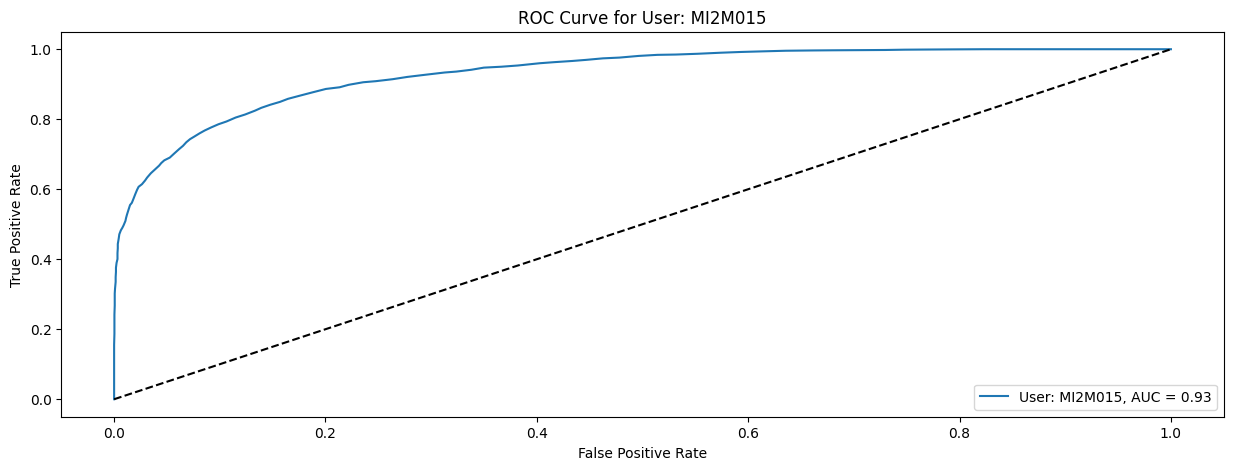

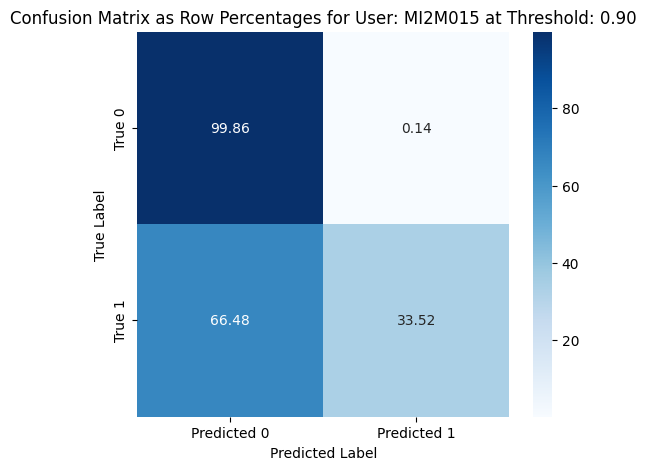

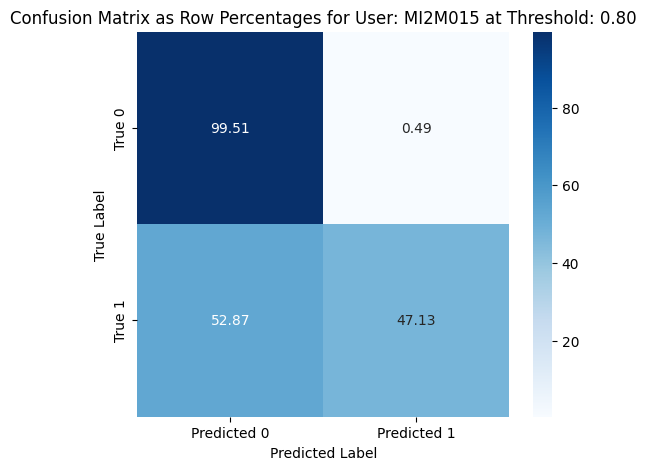

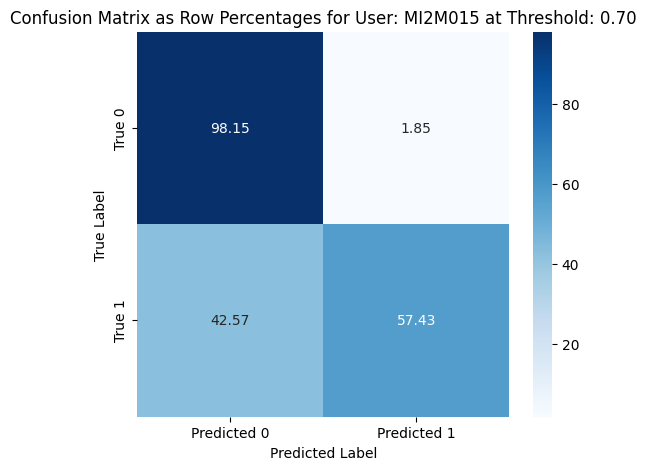

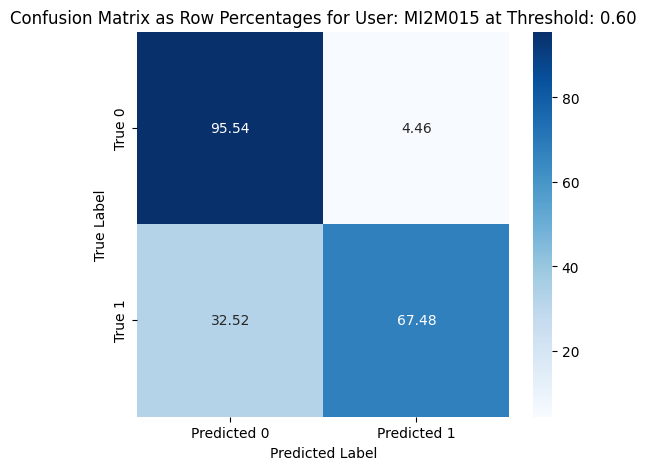

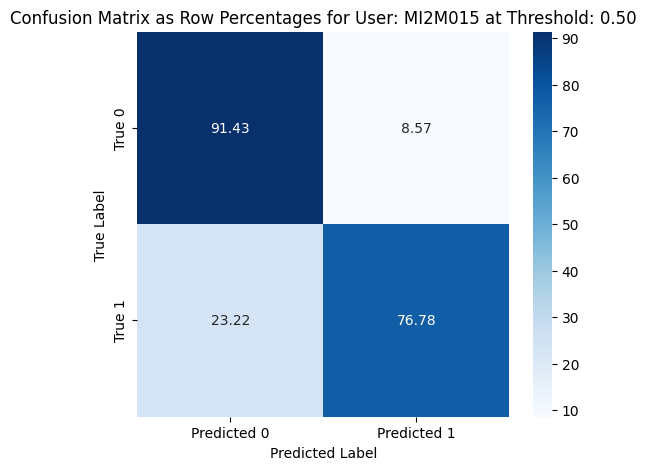

In [308]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

test = ["MI2M015"]

unique_users = trial_data['user'].unique()

for user in test:
    # Filter data for the current user
    user_data = trial_data[trial_data['user'] == user].copy()
    user_data = user_data.drop(columns=['documentation_day', 'user','x_mean', 'y_mean', 'z_mean', 'x_std', 'y_std', 'z_std', 
                                        'rms', 'hrv'])

    # Convert 'med' to binary if necessary
    if user_data['med'].nunique() == 3:
        user_data['med'] = user_data['med'].replace({1: 0, 2: 1})

    # Split the data into features and target
    X = user_data.drop('med', axis=1)
    y = user_data['med']

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Train a simple Random Forest model
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)

    # Predict probabilities for the test set
    y_pred_proba = rf.predict_proba(X_test)[:, 1]

    # Calculate ROC curve and AUC score
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    # Plot the AUC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'User: {user}, AUC = {auc_score:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for User: {user}')
    plt.legend(loc='lower right')
    plt.show()

    # Generate and plot heatmaps for each threshold
    for threshold in [0.9,0.8,0.7,0.6,0.5]:
        # Binarize predictions based on the threshold
        y_pred = (y_pred_proba >= threshold).astype(int)

        # Calculate TP, FP, TN, FN
        tp = ((y_pred == 1) & (y_test == 1)).sum()
        fp = ((y_pred == 1) & (y_test == 0)).sum()
        tn = ((y_pred == 0) & (y_test == 0)).sum()
        fn = ((y_pred == 0) & (y_test == 1)).sum()
        
        # Calculate row-wise percentages
        true_0_total = tn + fp
        true_1_total = fn + tp
        conf_matrix_percent = [
            [tn / true_0_total * 100 if true_0_total > 0 else 0, fp / true_0_total * 100 if true_0_total > 0 else 0],
            [fn / true_1_total * 100 if true_1_total > 0 else 0, tp / true_1_total * 100 if true_1_total > 0 else 0]
        ]

        # Plot heatmap
        plt.figure(figsize=(6, 5))
        sns.heatmap(conf_matrix_percent, annot=True, fmt=".2f", cmap="Blues",
                    xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["True 0", "True 1"])
        plt.title(f'Confusion Matrix as Row Percentages for User: {user} at Threshold: {threshold:.2f}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()


# 5. Post-GNN Consolidated Weekly Graphs of Observational Data <a class="anchor" id="5"></a>


In [280]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

target_column = 'med'  
exclude_columns = ['time_since_med', 'user']  


X_train = trial_data.drop(columns=['x_mean', 'y_mean', 'z_mean', 'x_std', 'y_std', 'z_std', 'rms', 'hrv',
       'user', 'med', 'documentation_day']  )
y_train = trial_data[target_column]

X_test = users_daily.drop(columns=['time_since_med', 'x_mean', 'y_mean', 'z_mean', 'x_std', 'y_std',
       'z_std', 'rms', 'rec_num_acc', 'gx_mean', 'gy_mean', 'gz_mean',
       'gx_std', 'gy_std', 'gz_std', 'gx_zcr', 'gy_zcr', 'gz_zcr', 'g_rms',
       'rec_num_gyro', 'hrv_mean', 'hrv_std', 'rec_num_hrv', 'user', 'day',
       'date'])
#y_test = df2[target_column]

# Initialize the Random Forest classifier
rf = RandomForestClassifier()

# Train the model on df1
rf.fit(X_train, y_train)

# Predict probabilities on df2
y_pred_proba = rf.predict_proba(X_test)[:, 1]  # get probability of class 1
users_daily['predicted_proba'] = y_pred_proba



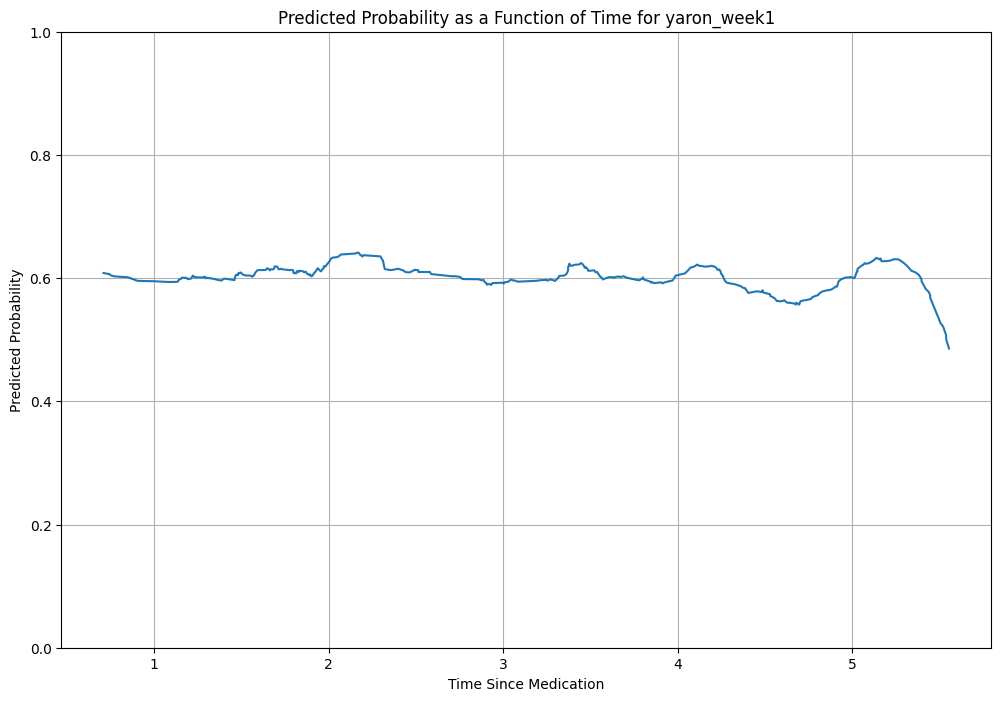

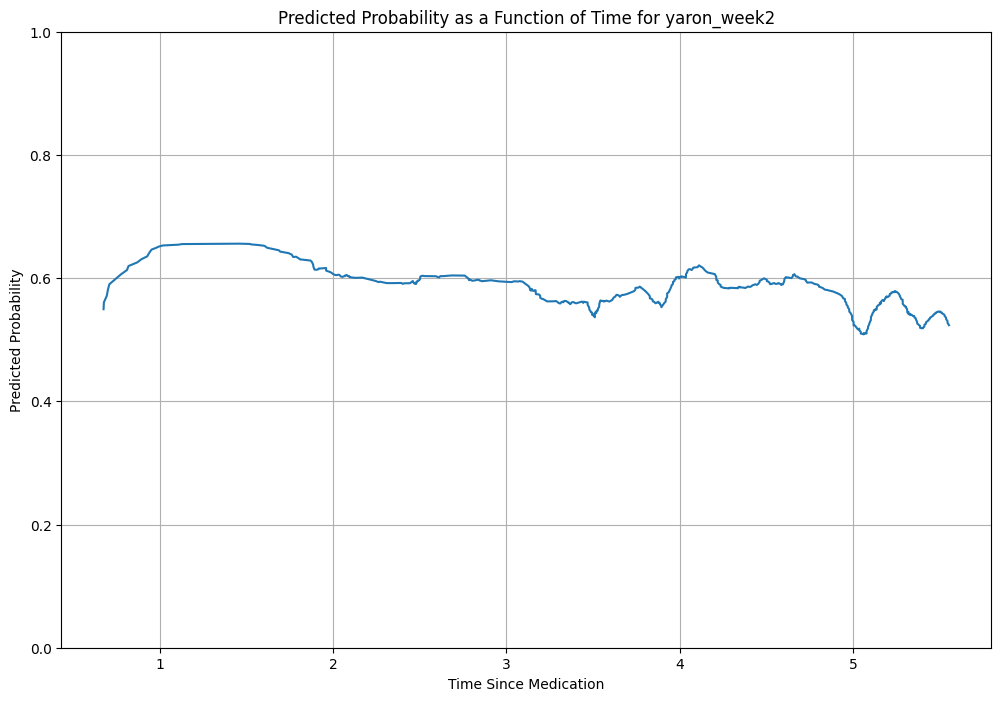

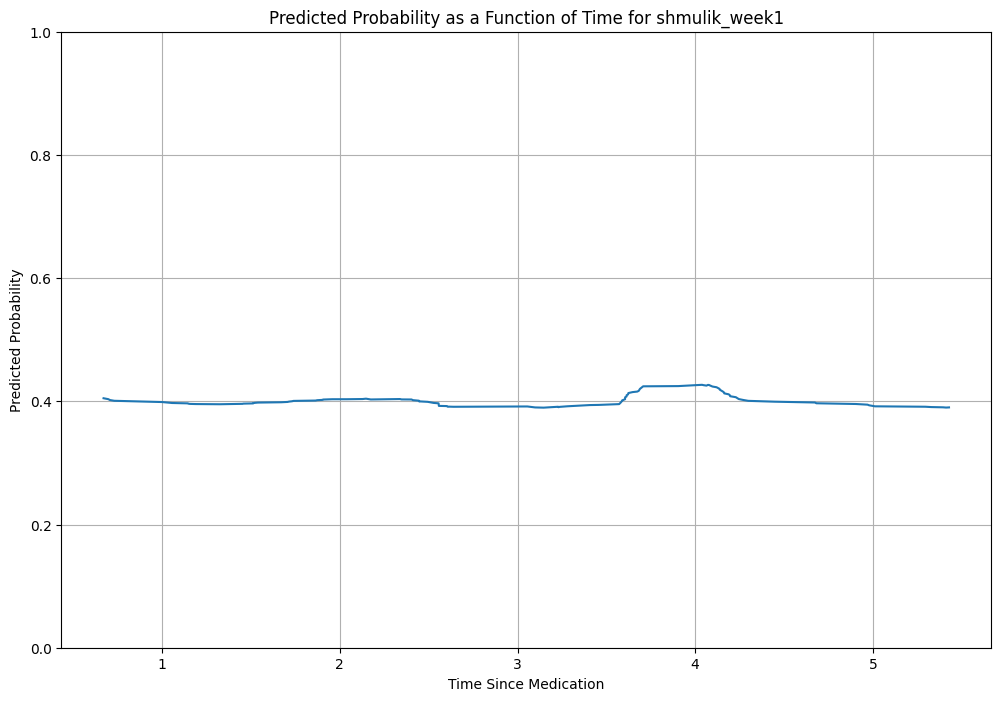

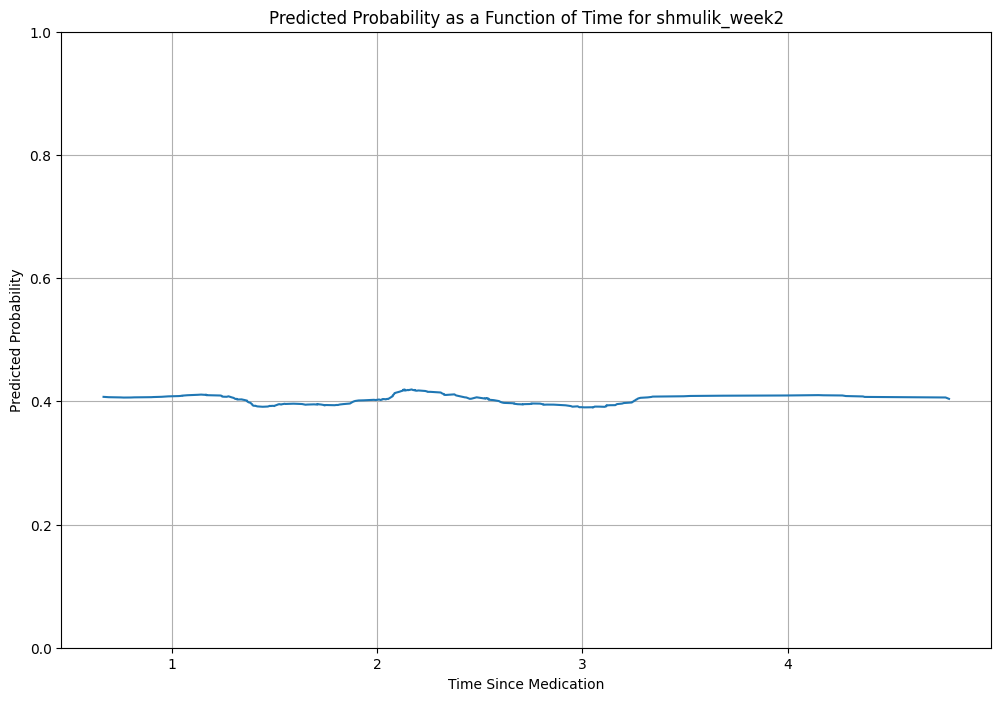

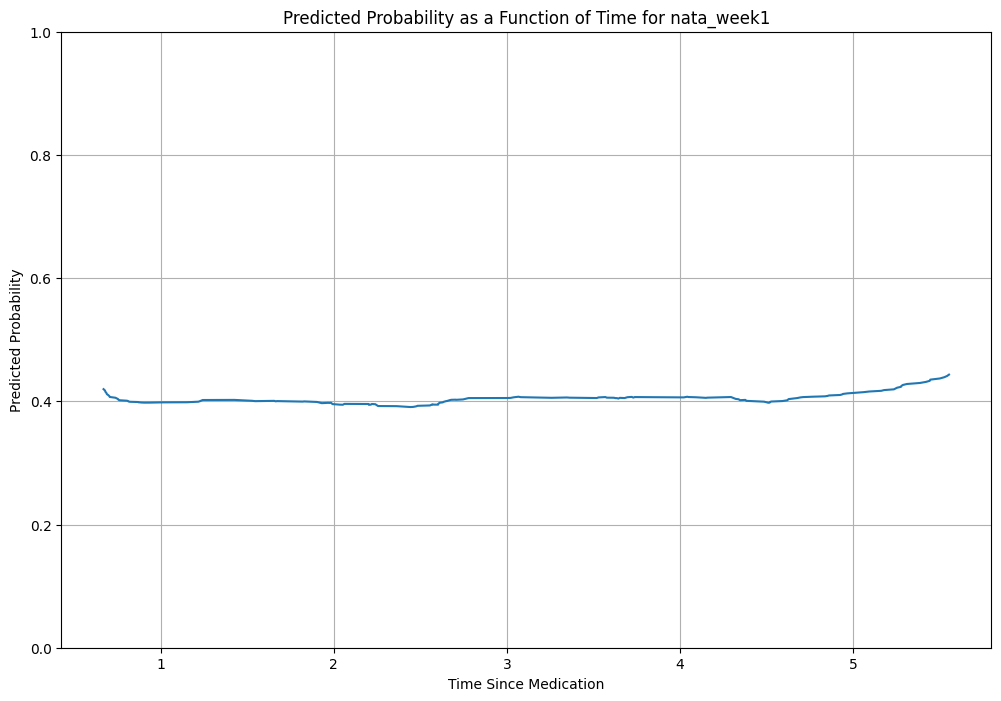

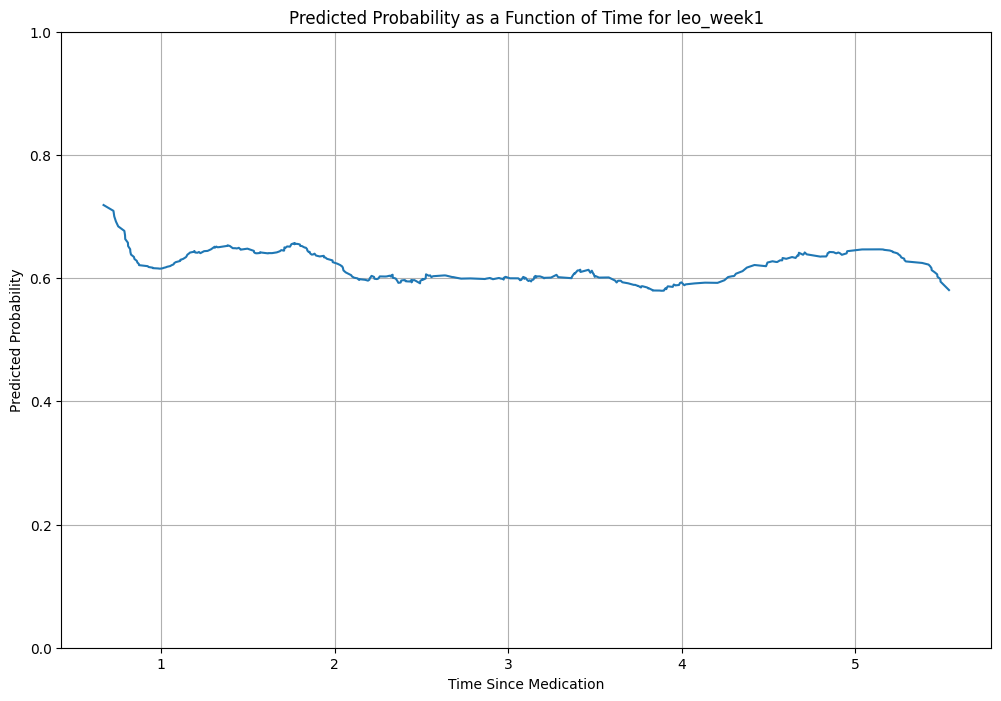

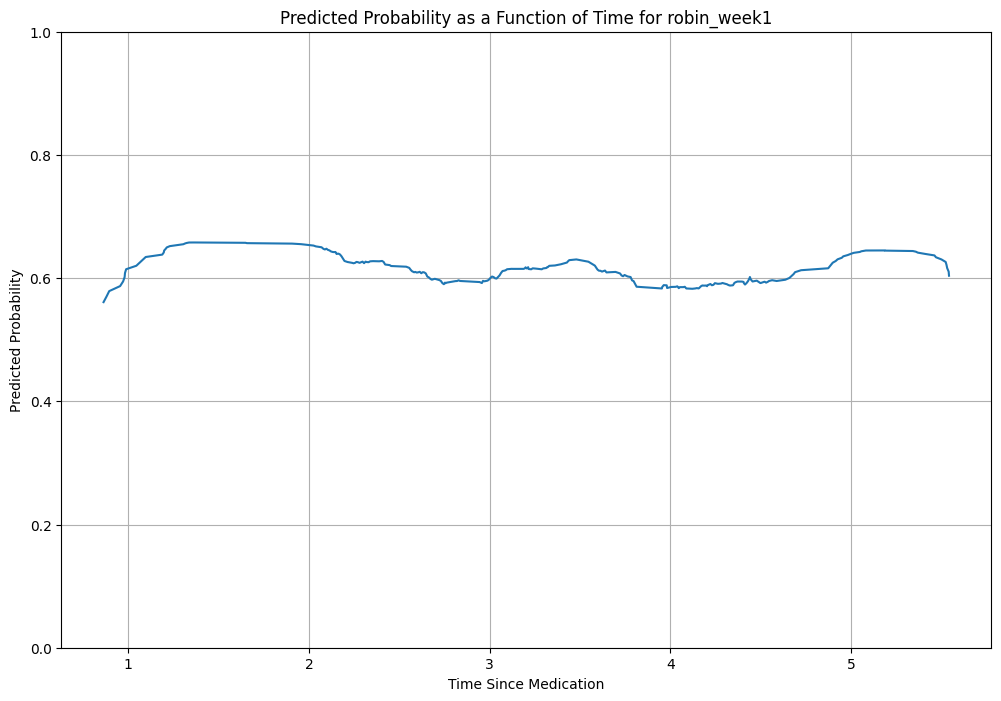

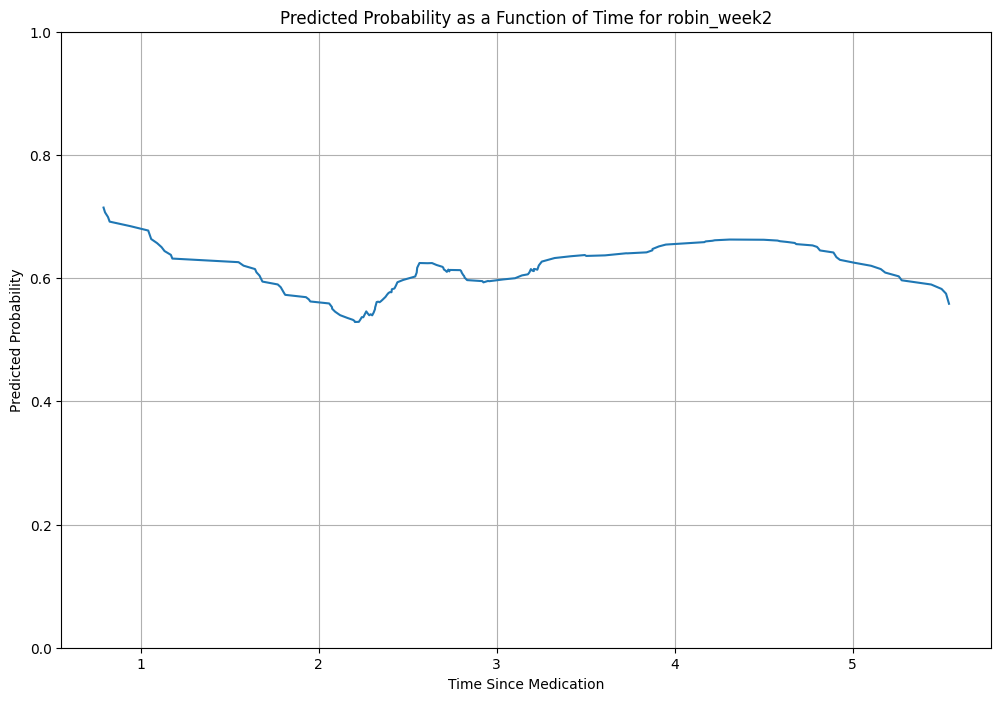

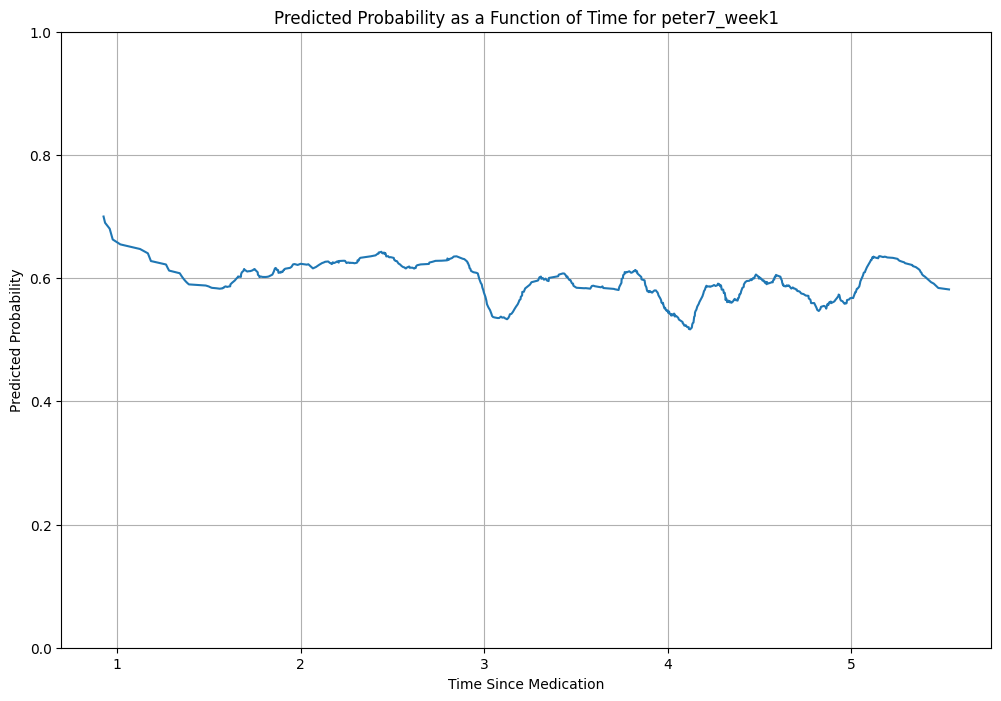

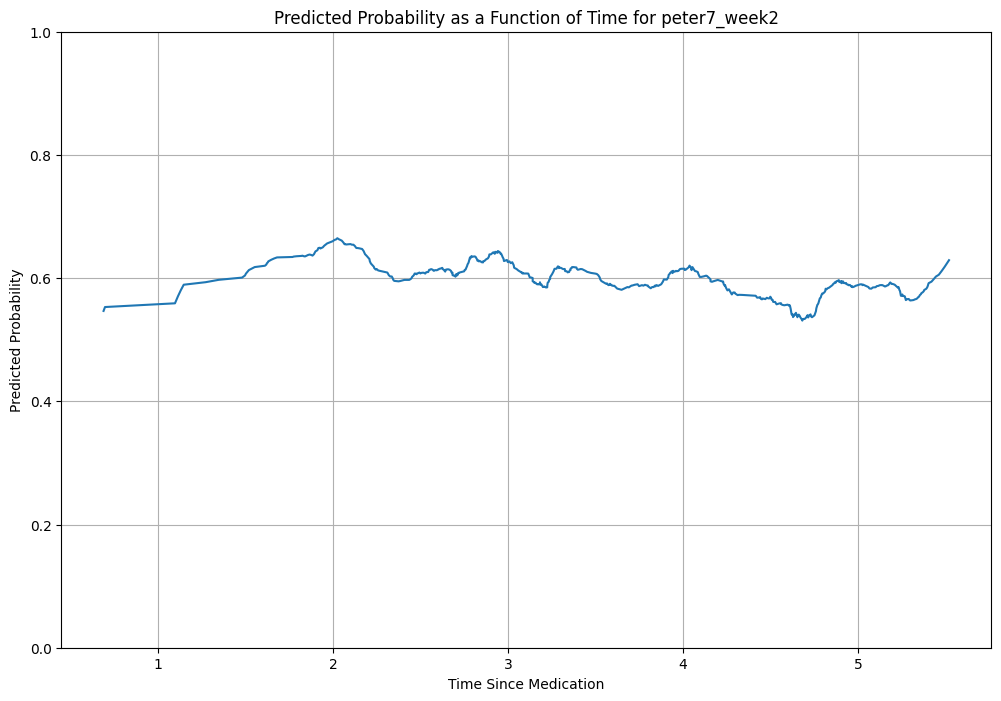

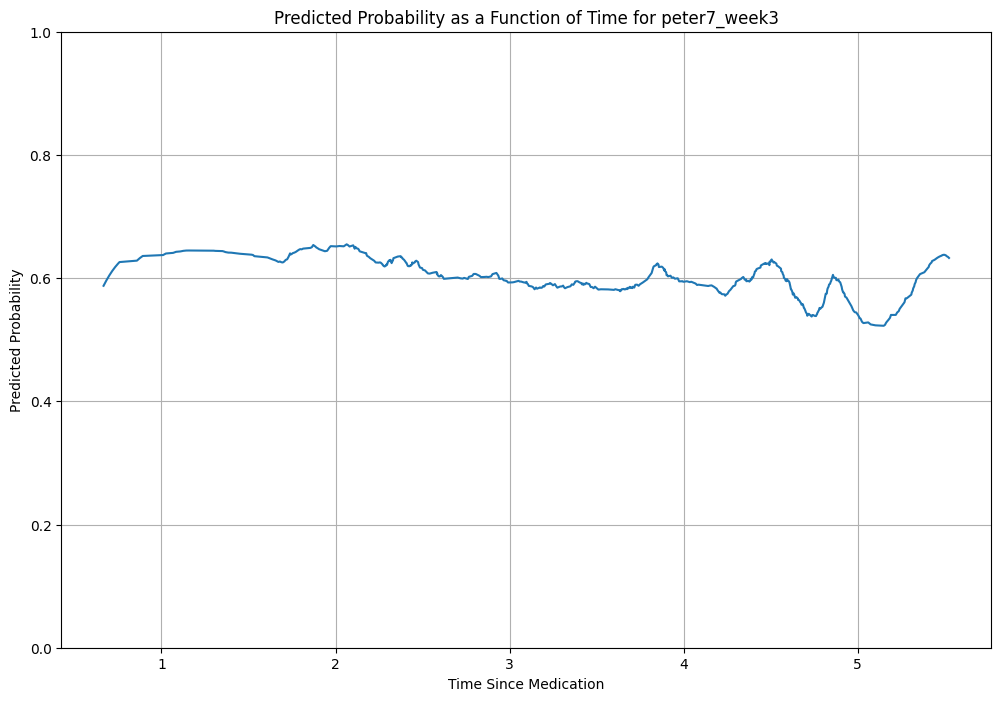

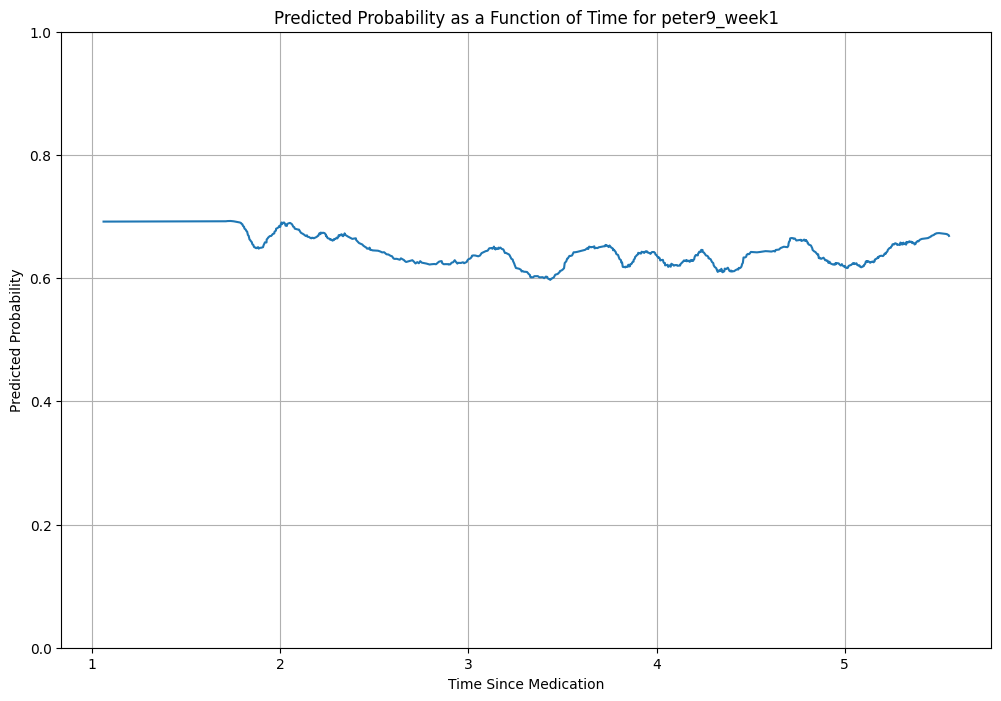

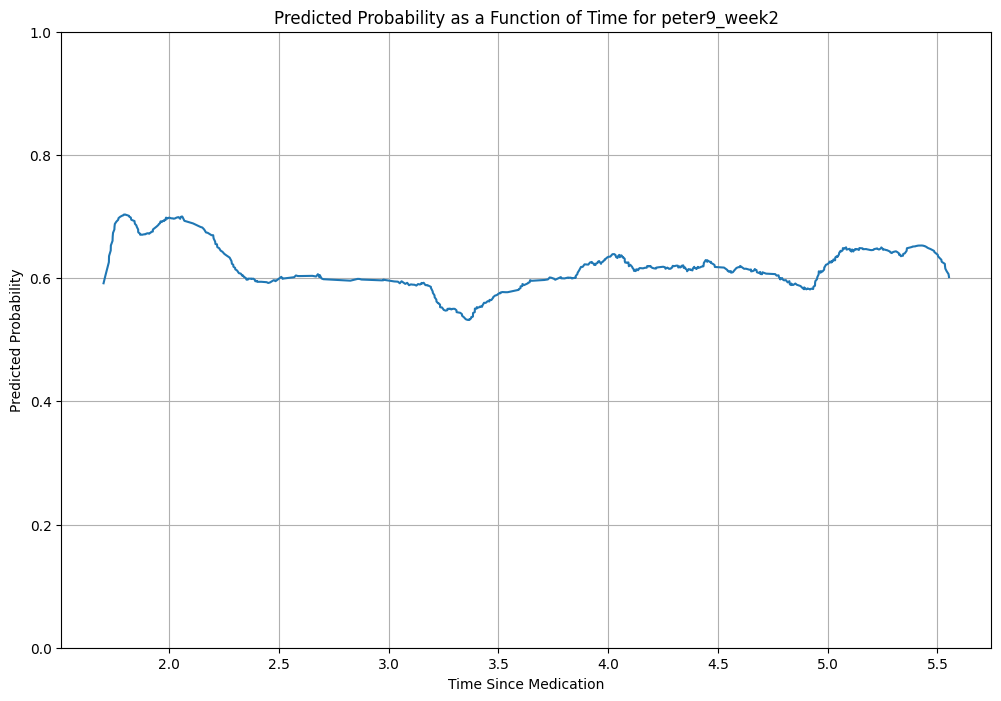

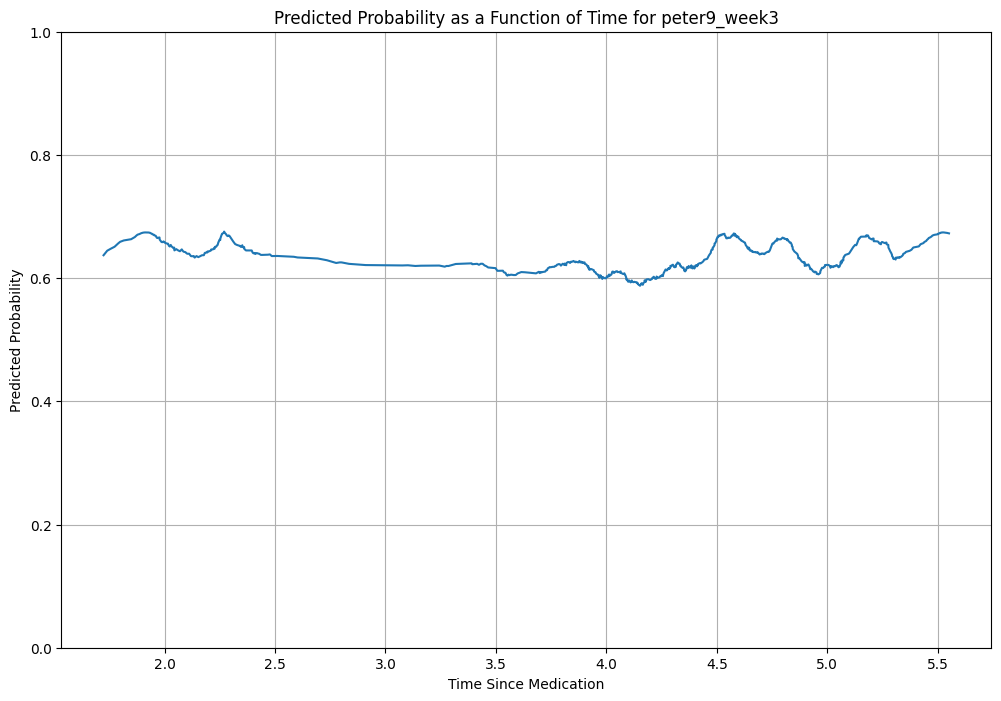

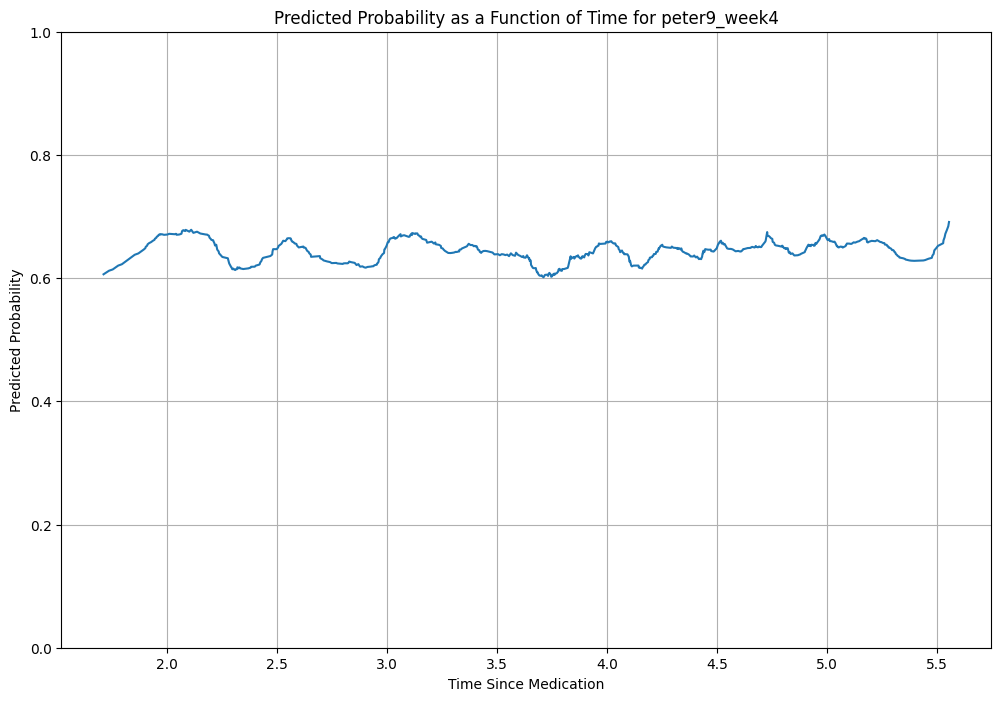

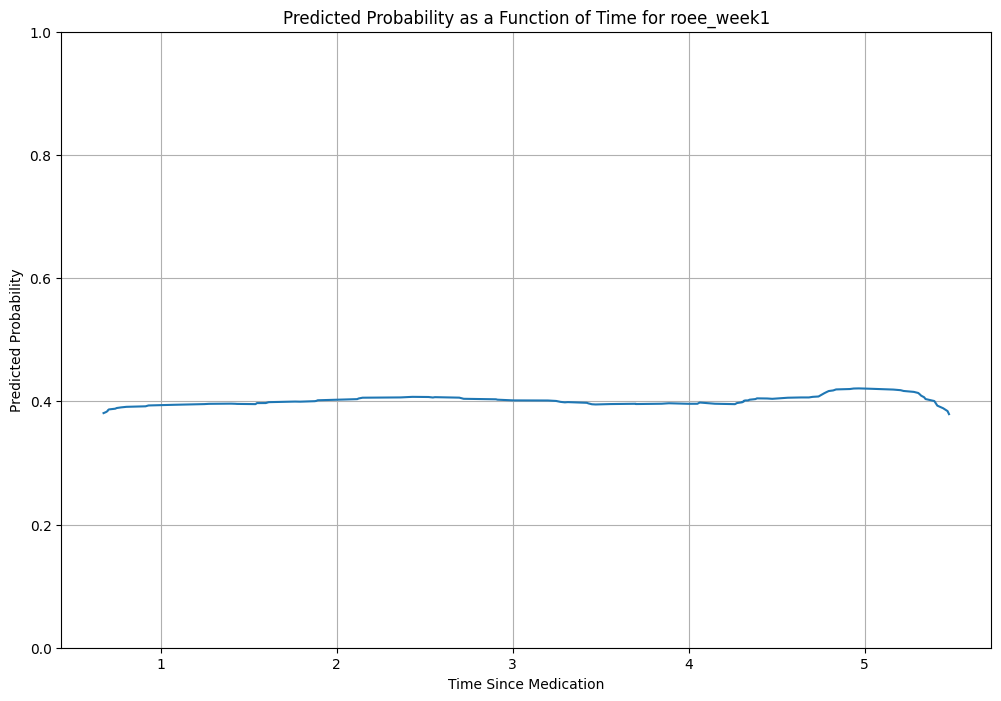

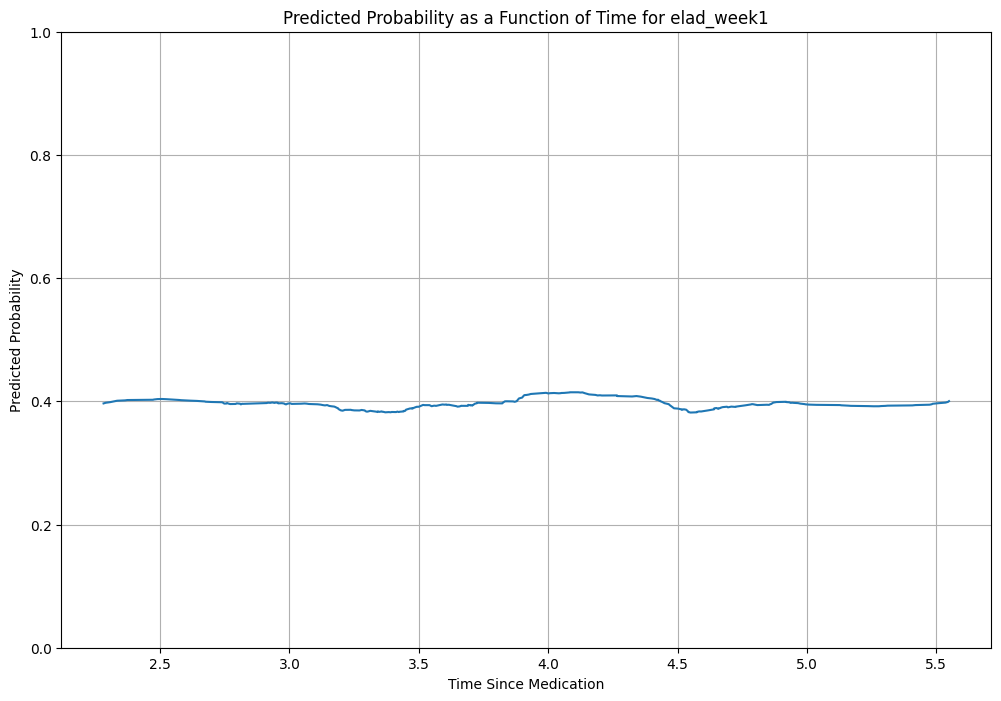

In [174]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

users = users_daily["user"].unique()

for user in users:
    df_filtered = users_daily[users_daily["user"] == user].sort_values(by='time_since_med')
    x = df_filtered['time_since_med']
    y = df_filtered['predicted_proba']
    plt.figure(figsize=(12, 8))
    y_savgol = savgol_filter(y, window_length=67, polyorder=3)
    plt.plot(x, y_savgol)
    plt.ylim(0, 1)
    plt.xlabel('Time Since Medication')
    plt.ylabel('Predicted Probability')
    plt.title(f'Predicted Probability as a Function of Time for {user}')
    plt.grid(True)
    plt.show()


In [133]:
X_train = trial_data.drop(columns=['day_time', 'user', 'med','x_mean', 'y_mean', 'z_mean', 'x_std', 'y_std', 'z_std', 
            'rms', 'rec_num_acc', 'gx_mean', 'gy_mean', 'gz_mean', 
            'gx_std', 'gy_std', 'gz_std', 'gx_zcr', 'gy_zcr', 'gz_zcr', 
            'g_rms', 'rec_num_gyro', 'hrv_mean', 'hrv_std', 'rec_num_hrv']  )

KeyError: "['day_time', 'rec_num_acc', 'gx_mean', 'gy_mean', 'gz_mean', 'gx_std', 'gy_std', 'gz_std', 'gx_zcr', 'gy_zcr', 'gz_zcr', 'g_rms', 'rec_num_gyro', 'hrv_mean', 'hrv_std', 'rec_num_hrv'] not found in axis"

In [135]:
users_daily.columns


Index(['time_since_med', 'x_mean', 'y_mean', 'z_mean', 'x_std', 'y_std',
       'z_std', 'rms', 'rec_num_acc', 'gx_mean', 'gy_mean', 'gz_mean',
       'gx_std', 'gy_std', 'gz_std', 'gx_zcr', 'gy_zcr', 'gz_zcr', 'g_rms',
       'rec_num_gyro', 'hrv_mean', 'hrv_std', 'rec_num_hrv', 'user', 'day',
       'date', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10',
       'x11', 'x12', 'x13', 'x14', 'x15', 'x16'],
      dtype='object')